In [2]:
# Clustering of timeseries data
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from VisualizationFunctions import plot_by_factor, AnalyzeClusters
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline

In [3]:
print('Reading in the data...')
agg = pd.read_csv('sku_labels.csv')
df = pd.read_csv('extracted_features.csv')
sales = pd.read_csv('aggregate_products.csv')
df.dropna(axis=1, inplace=True)

scale = MinMaxScaler()
skus = df['id']
df.set_index('id', inplace=True)
X = scale.fit_transform(df)
names = df.columns

Reading in the data...


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print('Running Dimentionality Reduction...')
dimred = TSNE(2)
tsnes = dimred.fit_transform(X)

#Merge tsne coordinates onto original df with sku_keys
plot_df = pd.DataFrame(tsnes).join(df.reset_index())

#Merge above tsne and features table to sku_key and categories
plot_df['sku_key'] = plot_df['id'].astype(int)
agg['sku_key'] = agg['sku_key'].astype(int)
plot_df = plot_df.merge(agg, how='left', on='sku_key')

colors=['b', 'r', 'g', 'y', 'm', 'orange', 'gold', 'skyblue']

Running Dimentionality Reduction...


In [5]:
plot_df.head()

,0,1,id,sales__abs_energy,sales__absolute_sum_of_changes,"sales__agg_autocorrelation__f_agg_""mean""","sales__agg_autocorrelation__f_agg_""median""","sales__agg_autocorrelation__f_agg_""var""","sales__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","sales__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""",...,sales__value_count__value_1,sales__value_count__value_inf,sales__value_count__value_nan,sales__variance,sales__variance_larger_than_standard_deviation,sku_key,sku_department,sku_subdepartment,sku_category,sku_subcategory
0,22.483915,25.307186,28,455.0,228.0,0.009909,-0.001607,0.001339,0.188732,0.359772,...,25.0,0.0,0.0,0.621100,0.0,28,TY,06,063,20G
1,18.813700,5.753131,34,186.0,226.0,-0.004615,-0.017574,0.001181,1.335614,-0.138257,...,78.0,0.0,0.0,0.236220,0.0,34,TY,4,11,35A
2,-53.056255,13.143605,100,6946.0,1549.0,0.009112,0.010989,0.001624,7.239437,-0.195348,...,157.0,0.0,0.0,5.145510,1.0,100,BH,02,38,C09
3,48.061001,-24.166861,152,78.0,85.0,-0.002430,-0.012023,0.001742,0.699379,-0.093300,...,16.0,0.0,0.0,0.109897,0.0,152,BH,02,139,00L
4,-25.316551,24.063744,182,4038.0,1163.0,-0.005931,-0.003367,0.001556,3.848592,0.159739,...,135.0,0.0,0.0,4.060313,1.0,182,TY,8,33,16K


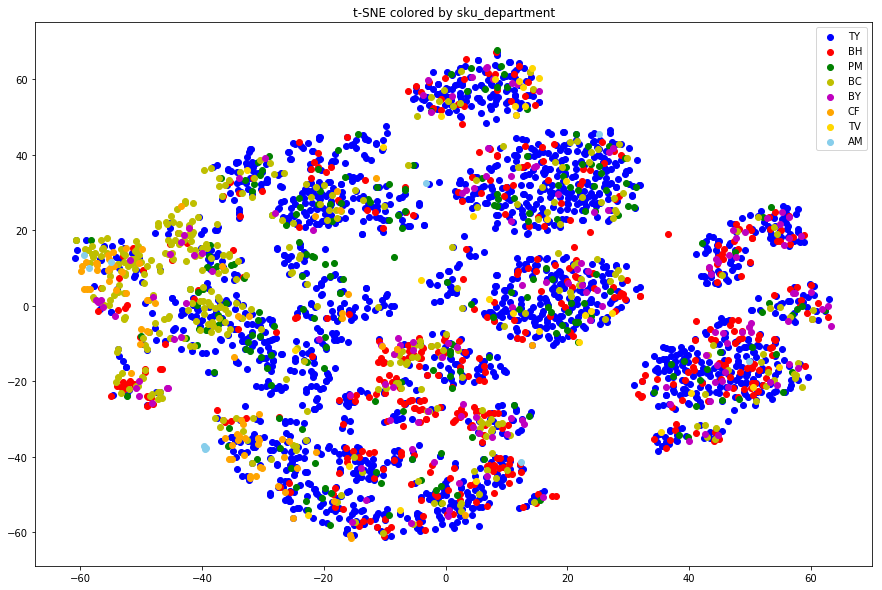

In [6]:
plot_by_factor(plot_df, 'sku_department', colors, showplot=True)

In [7]:
sales_df = sales.groupby('sku_key').sum().reset_index()[['sku_key', 'sales']].merge(plot_df, on='sku_key')[['sku_key', 'sales', 0,1]]
sales_df['class'] = [25 if x <= 50 else 75 if x <= 100 else 175 if x <= 250 \
                     else 375 if x <= 500 \
                     else 775 if x <=1000 else 2000 for x in sales_df['sales']]

In [8]:
sales_df['class'].value_counts()

25      797
175     785
75      592
375     479
775     310
2000    230
Name: class, dtype: int64

In [9]:
sales_df['sales_log'] = np.log10(sales_df['sales'])

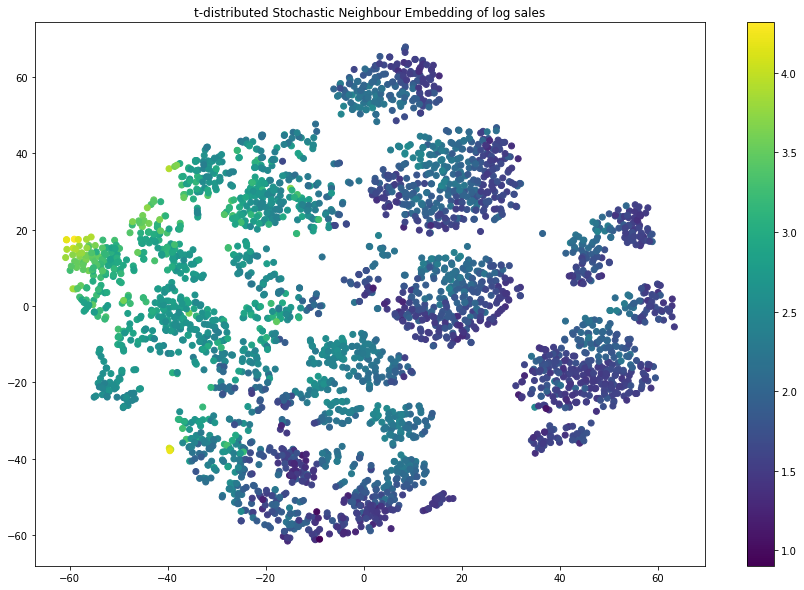

In [10]:
f, ax = plt.subplots(figsize=(15,10))
sc = ax.scatter(sales_df[0], sales_df[1], c=sales_df['sales_log'], cmap='viridis')
plt.colorbar(sc)
ax.set_title('t-distributed Stochastic Neighbour Embedding of log sales')
plt.show()
f.savefig('./images/cumulative_sales.png')

## SOM

In [53]:
colors = ['darkblue', 'tomato', 'orchid', 'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r', 'brown']
run_cont = ['sales', 'selling_price', 'avg_discount']
run_cats = ['sku_department', 'sku_subdepartment', 'sku_category', 'sku_subcategory']

product_sales = pd.read_csv('aggregate_products.csv')
som_clus = pd.read_csv('som_clusters.csv')
som_clus.columns = ['sku_key', 'cluster']

analyze_som = AnalyzeClusters()
df_dict = analyze_som.make_dataset(product_sales, som_clus)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)




 sku_department


 sku_subdepartment


 sku_category


 sku_subcategory


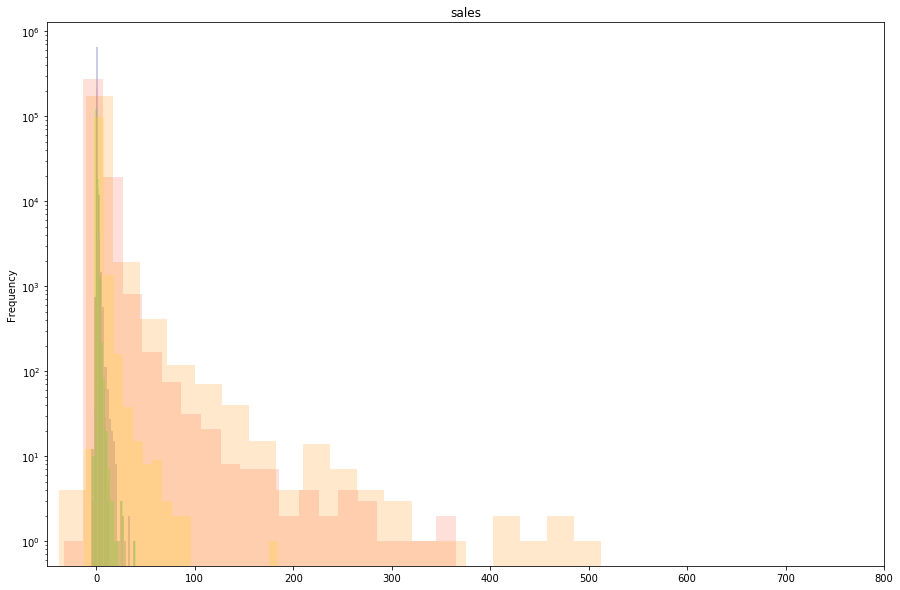

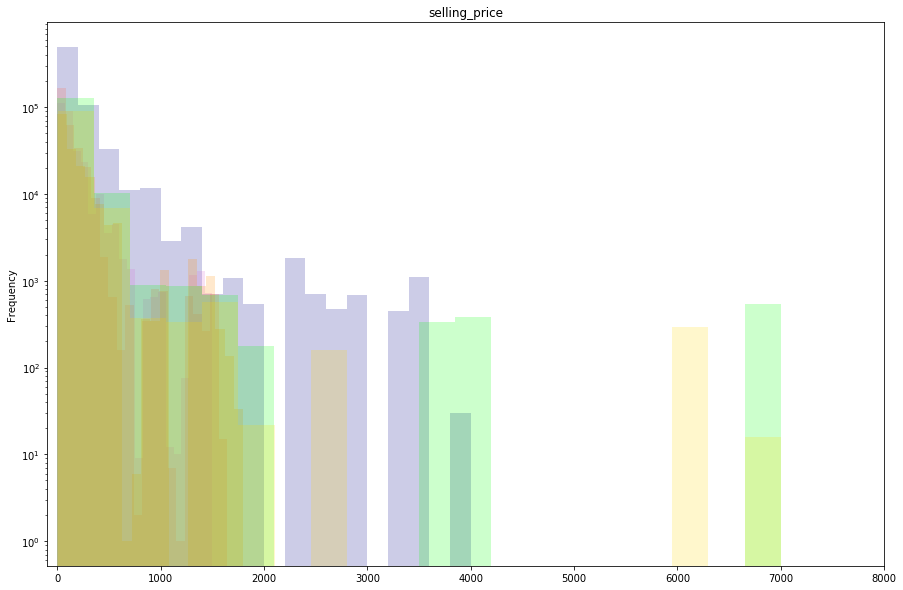

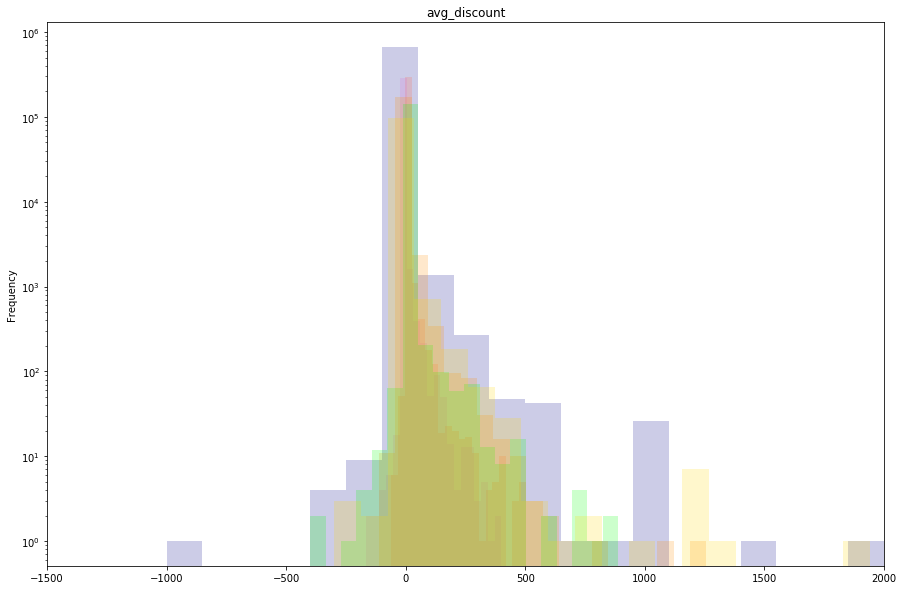

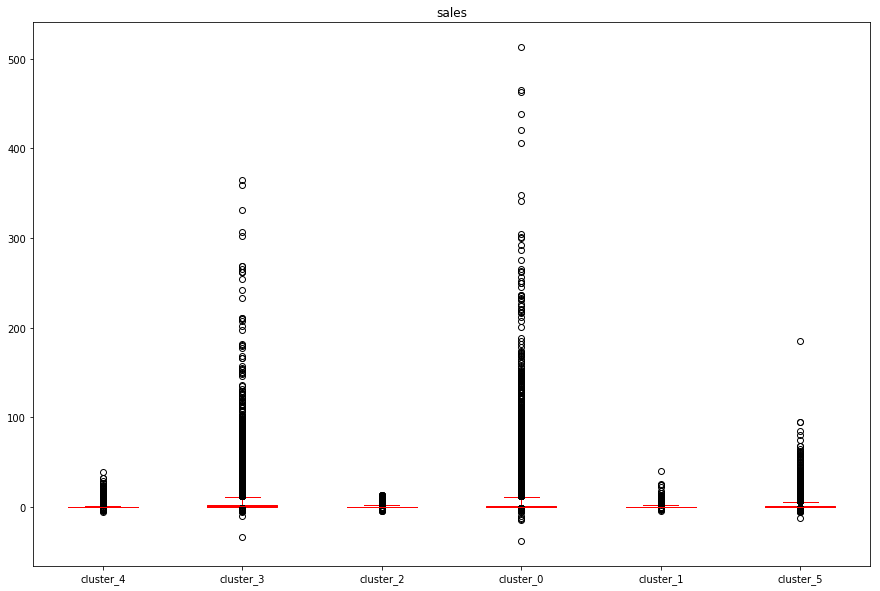

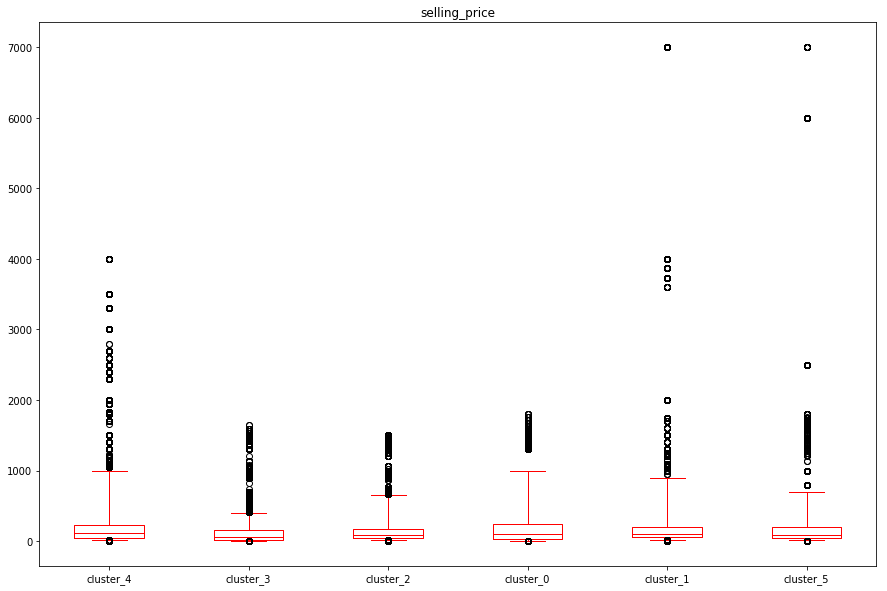

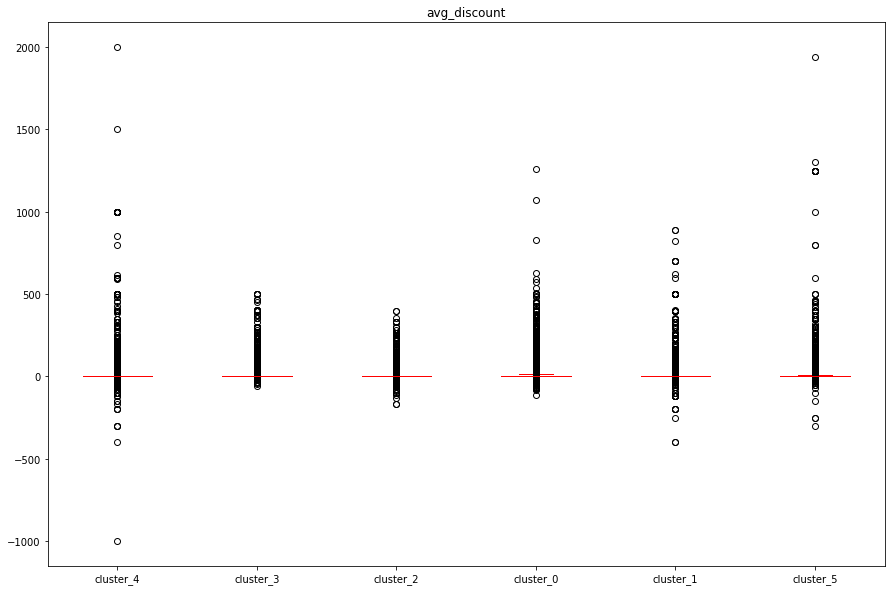

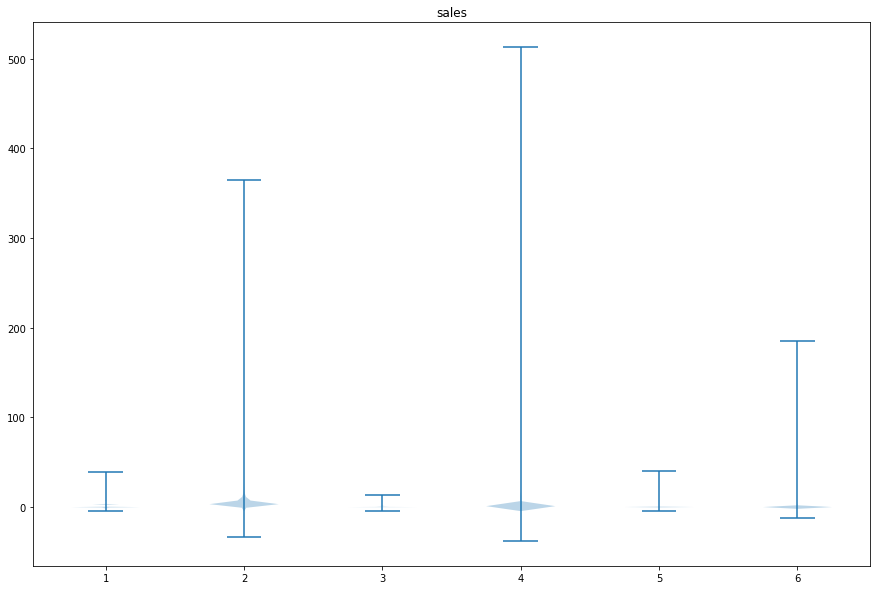

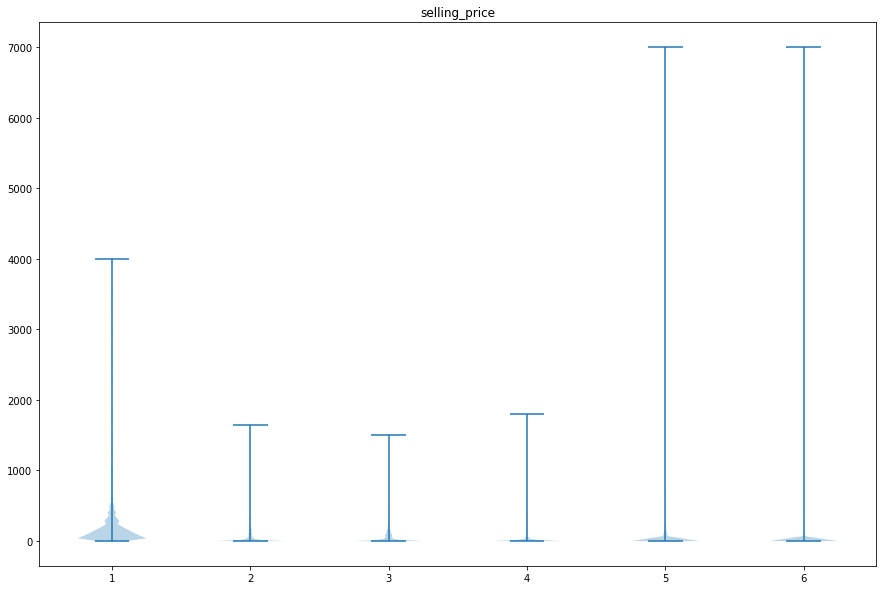

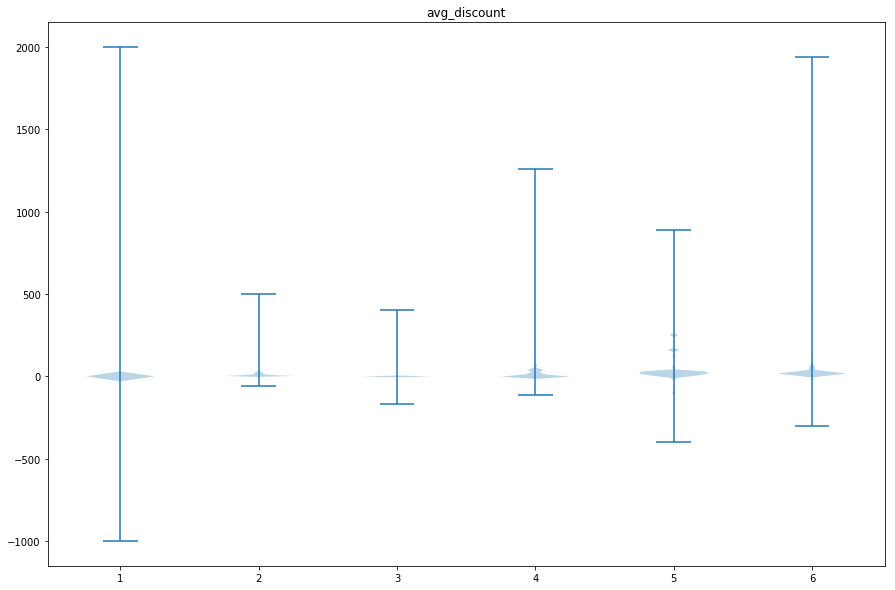

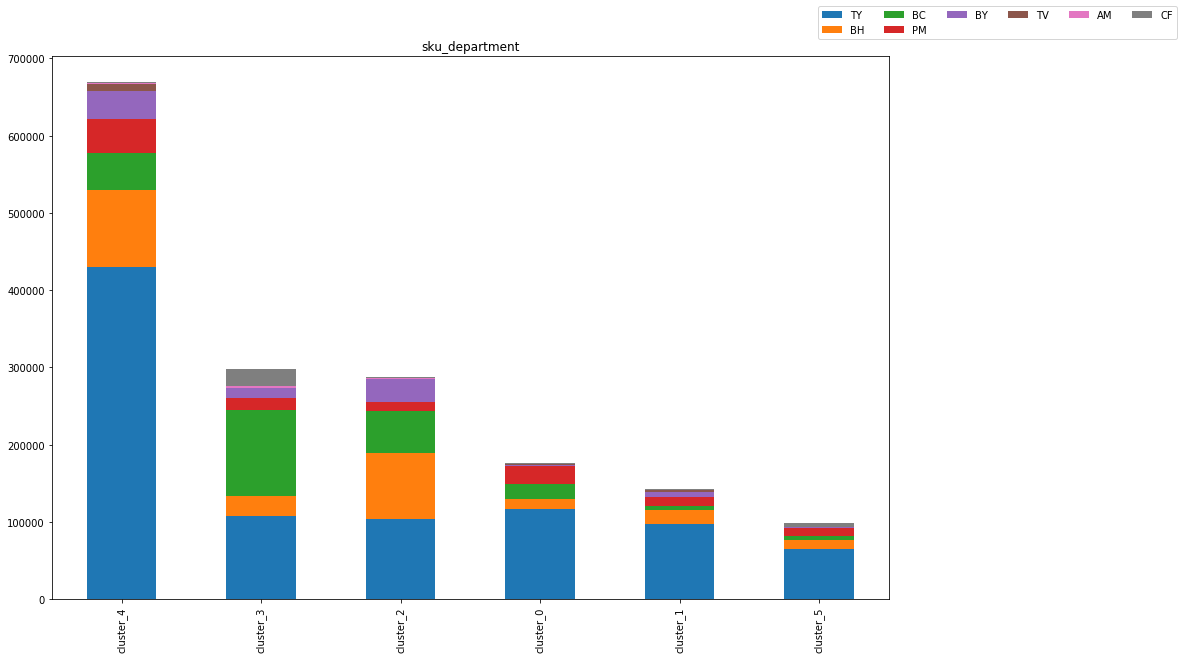

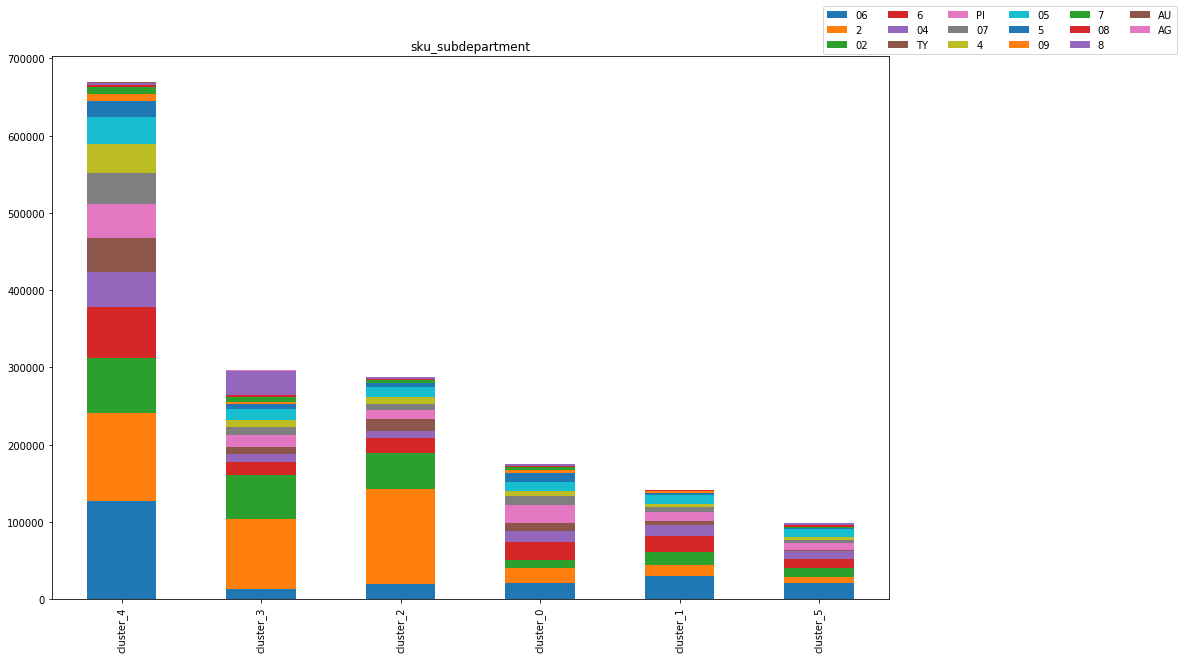

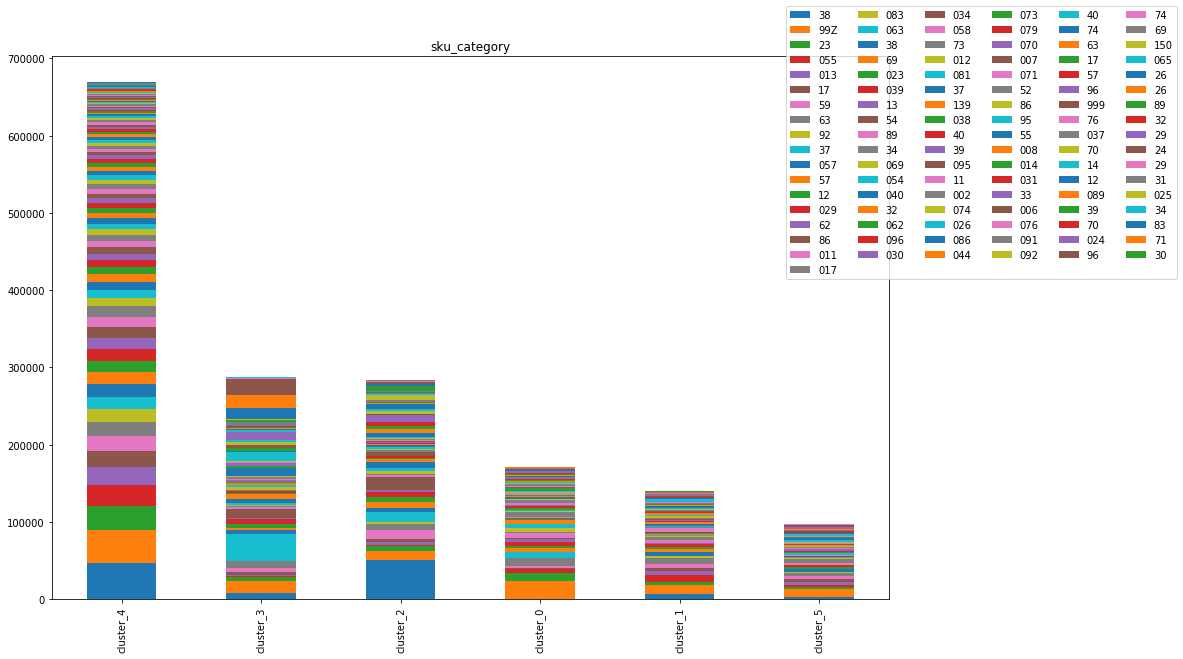

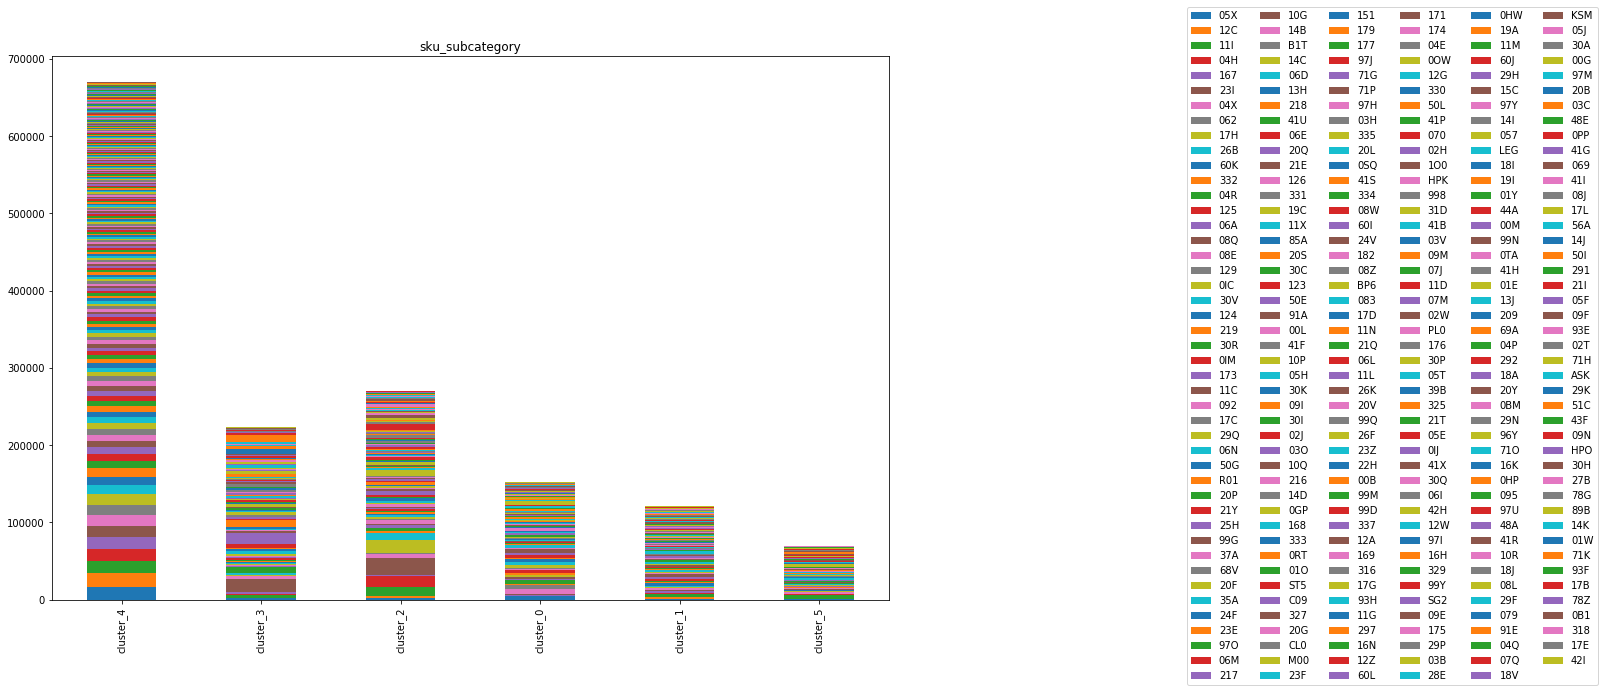

In [54]:
analyze_som.plot_cluster_continuous(df_dict, run_cont, colors, False)
analyze_som.plot_cluster_continuous_box(df_dict, run_cont, False)
analyze_som.plot_cluster_continuous_violin(df_dict, run_cont, False)
analyze_som.plot_cluster_categorical(df_dict, run_cats, False)

In [13]:
analyze_som.test_continuous_feat(df_dict, run_cont)


 
 sales
                sum_sq         df             F  PR(>F)
cluster   9.306368e+05        5.0  17924.944399     0.0
Residual  1.738394e+07  1674156.0           NaN     NaN 

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
cluster_0 cluster_1 -1.3519  -1.3846 -1.3191  True 
cluster_0 cluster_2 -1.1937  -1.2214 -1.1659  True 
cluster_0 cluster_3  0.4584   0.4308  0.486   True 
cluster_0 cluster_4 -1.4178  -1.4424 -1.3932  True 
cluster_0 cluster_5 -0.5868  -0.6233 -0.5503  True 
cluster_1 cluster_2  0.1582   0.1284  0.188   True 
cluster_1 cluster_3  1.8103   1.7807  1.8398  True 
cluster_1 cluster_4  -0.066  -0.0928 -0.0391  True 
cluster_1 cluster_5  0.7651   0.727   0.8031  True 
cluster_2 cluster_3  1.6521   1.6281  1.676   True 
cluster_2 cluster_4 -0.2241  -0.2446 -0.2037  True 
cluster_2 cluster_5  0.6069   0.573   0.6407  True 
cluster_3 cluster_4 -1.8762  -1.8964  -1

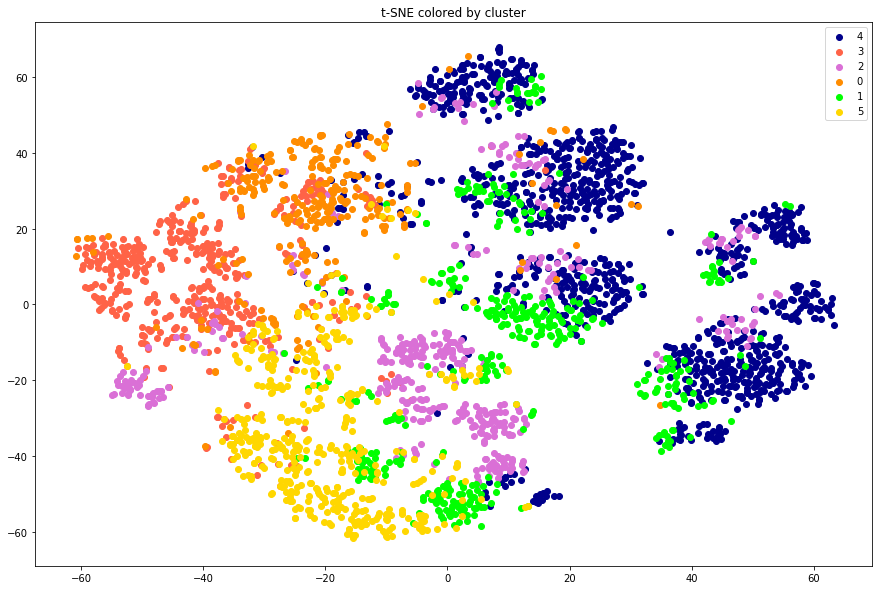

In [55]:
som_tsne = plot_df.merge(som_clus, left_on='id', right_on='sku_key')

plot_by_factor(som_tsne, 'cluster', colors, False)

In [15]:
som_sales_df = sales_df.merge(som_clus, on='sku_key')
som_sales_df.head()

,sku_key,sales,0,1,class,sales_log,cluster
0,28,119,22.483915,25.307186,175,2.075547,4
1,34,122,18.813700,5.753131,175,2.086360,4
2,100,1530,-53.056255,13.143605,2000,3.184691,3
3,152,44,48.061001,-24.166861,25,1.643453,4
4,182,914,-25.316551,24.063744,775,2.960946,3


cluster 4
1113


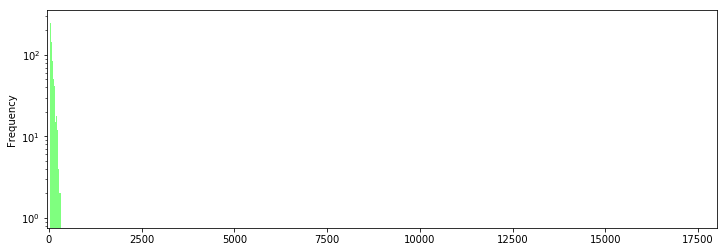

cluster 3
464


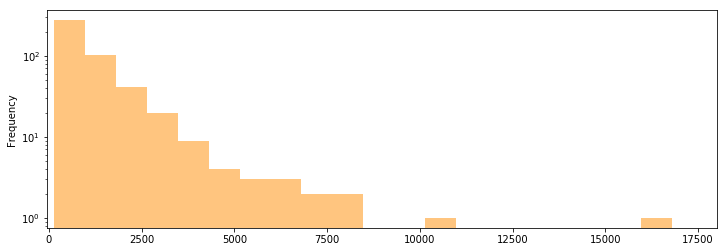

cluster 2
441


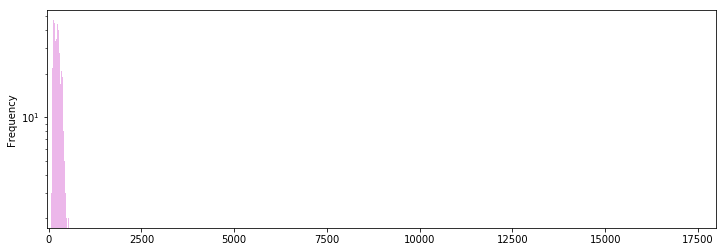

cluster 0
286


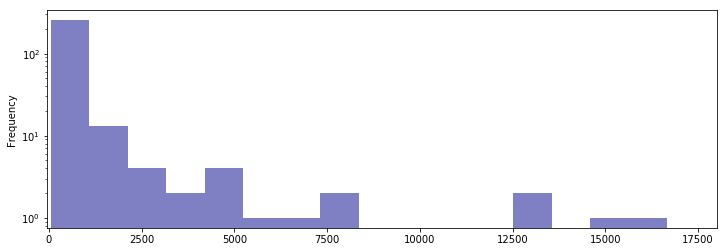

cluster 1
438


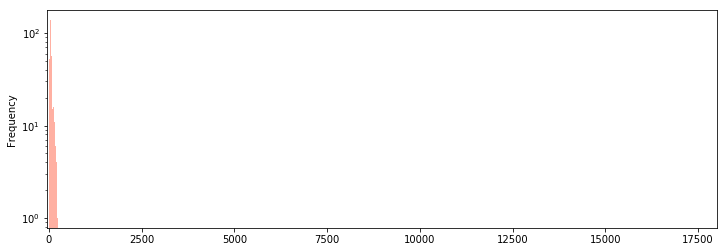

cluster 5
451


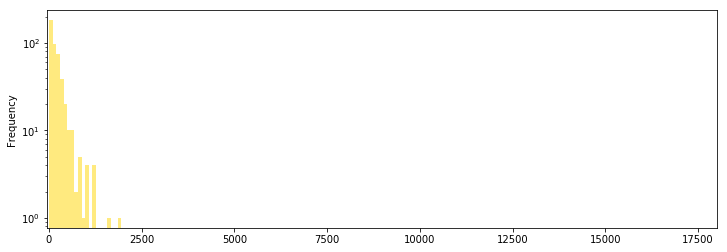

In [16]:
for i in som_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(som_sales_df[som_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    som_sales_df[som_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 18000)
    plt.show()
    f.savefig('images/som/som_cumulativesales_{}.png'.format(i))

In [17]:
for a, i in enumerate(som_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


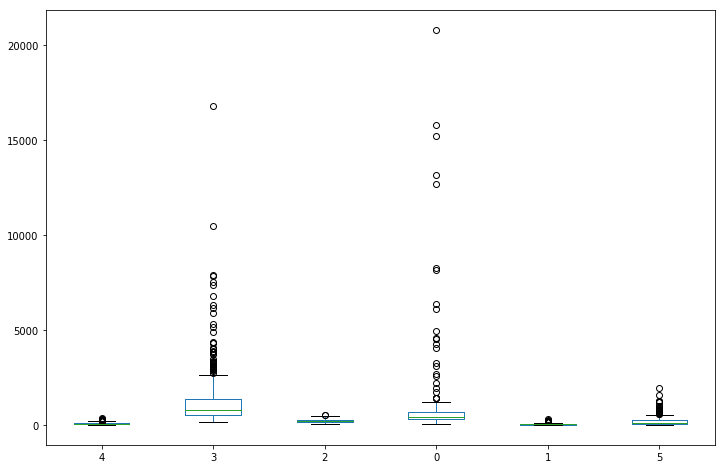

In [18]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)
f.savefig('images/som/som_cumulativesales_box.png')

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [20]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

,cluster,value
0,4,119.0
1,4,122.0
3,4,44.0
6,4,62.0
11,4,37.0


In [21]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df          F        PR(>F)
cluster   5.337753e+07     1.0  56.566962  7.019791e-14
Residual  3.011081e+09  3191.0        NaN           NaN


In [22]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper    reject
-----------------------------------------------------
  0      1    -890.9324  -1079.7785 -702.0863   True 
  0      2    -723.2793  -911.8715  -534.6872   True 
  0      3     334.8205   148.0762   521.5648   True 
  0      4    -876.5065  -1041.1851  -711.828   True 
  0      5    -743.3833  -931.1511  -555.6154   True 
  1      2     167.6531    0.0828    335.2233   True 
  1      3    1225.7529  1060.2651  1391.2407   True 
  1      4     14.4259   -125.6876   154.5394  False 
  1      5     147.5492   -19.0928   314.1911  False 
  2      3    1058.0998   892.9018  1223.2978   True 
  2      4    -153.2272  -292.9983   -13.4561   True 
  2      5     -20.1039  -186.4581   146.2502  False 
  3      4    -1211.327  -1348.5946 -1074.0594  True 
  3      5    -1078.2037  -1242.46  -913.9474   True 
  4      5     133.1233   -5.5336    271.7801  False 
----------------------------

## t-SNE



 sku_department


 sku_subdepartment


 sku_category


 sku_subcategory


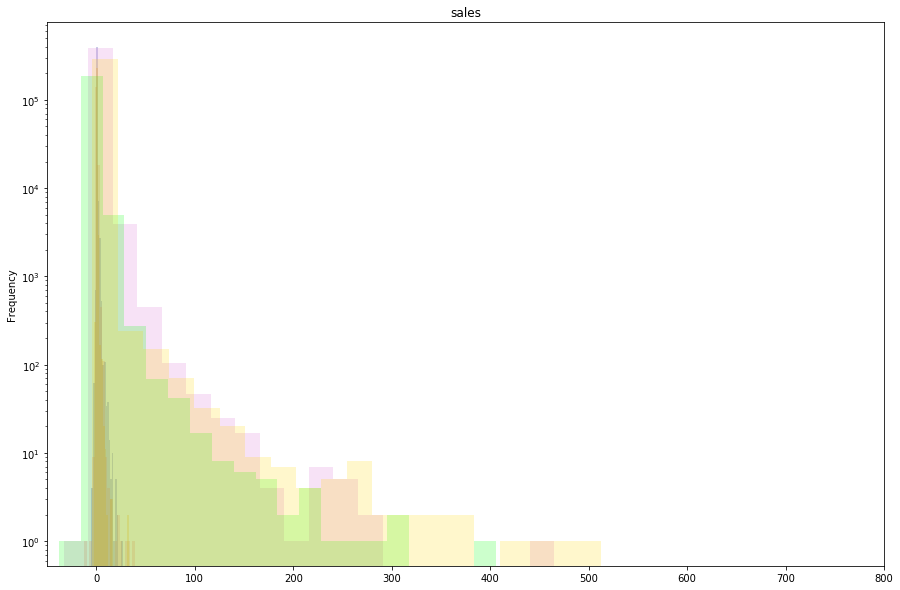

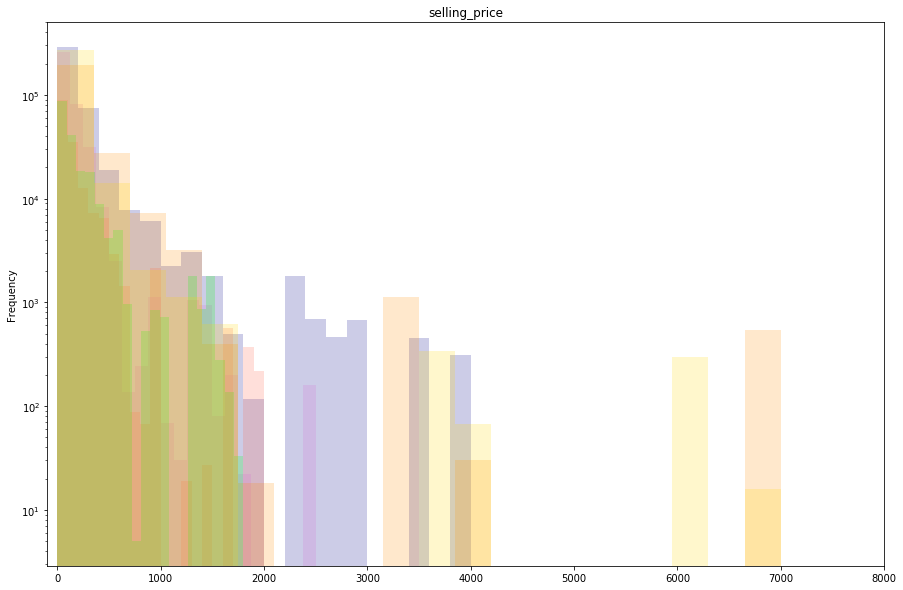

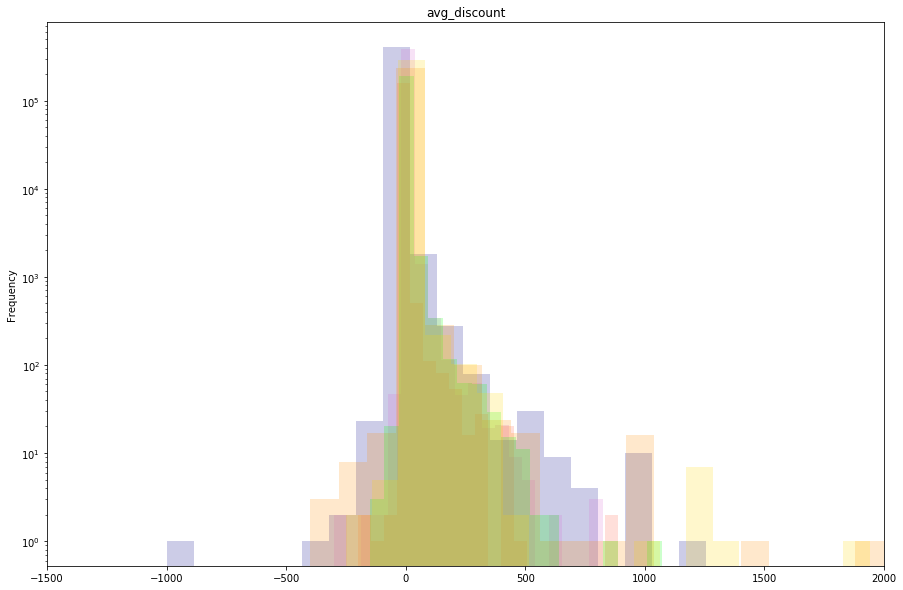

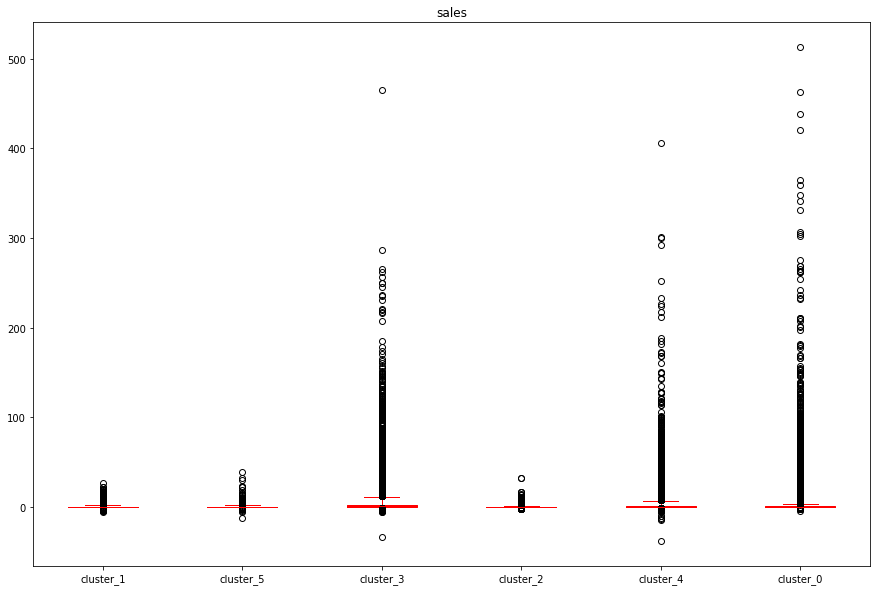

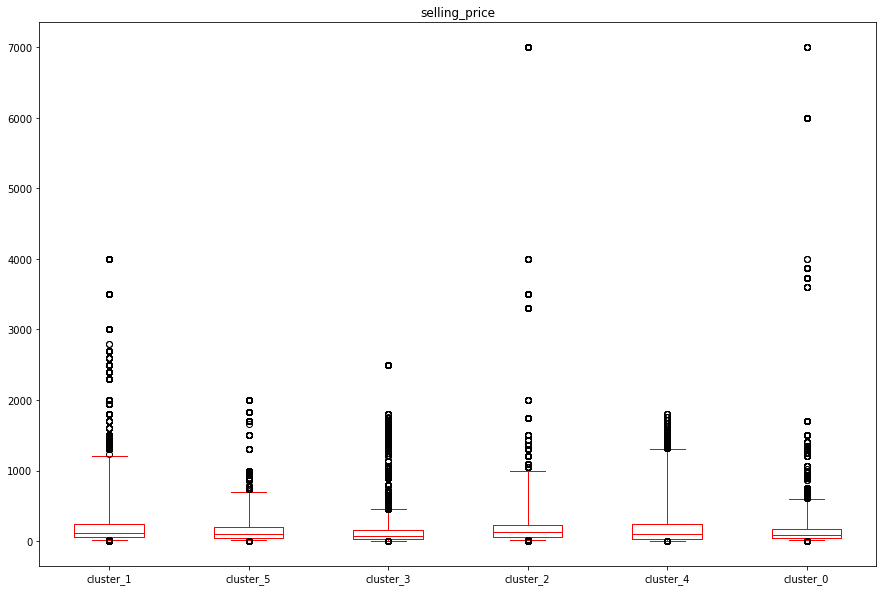

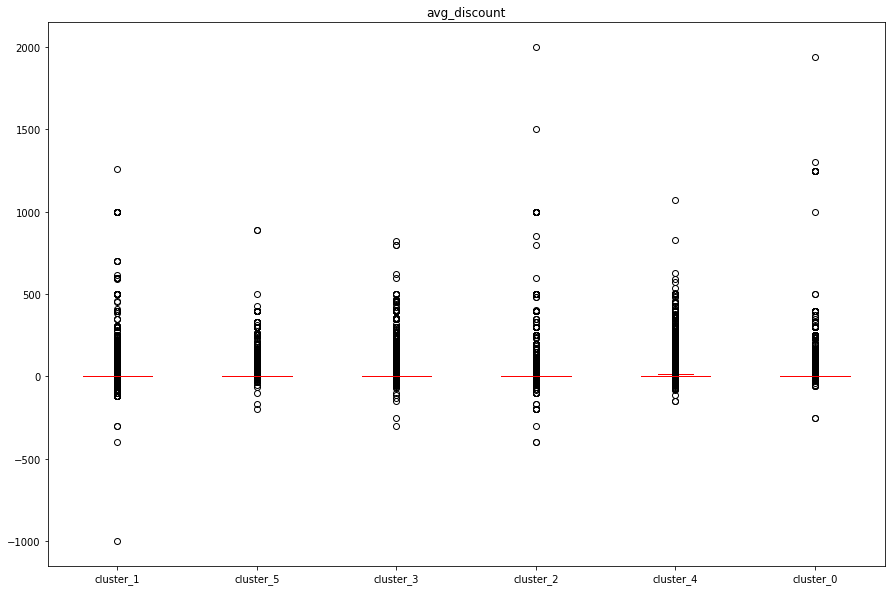

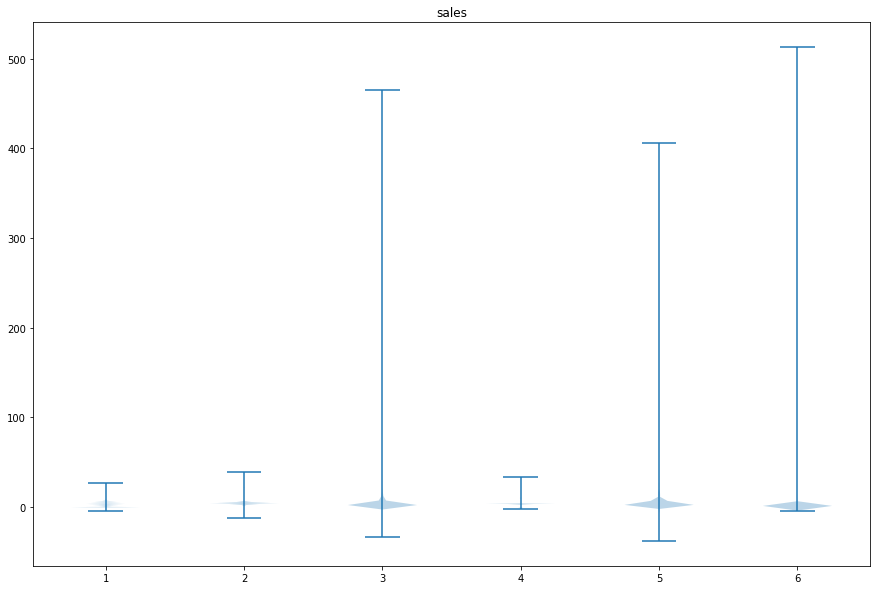

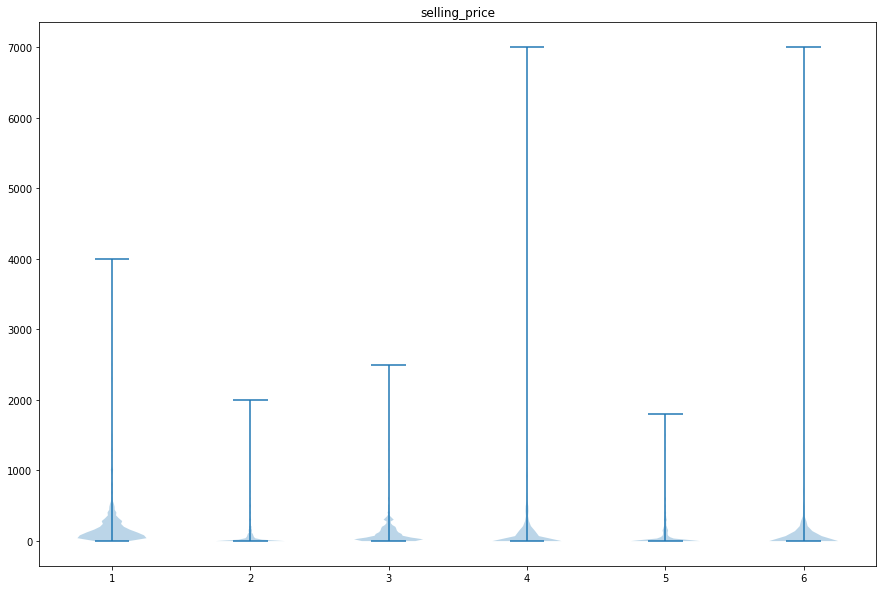

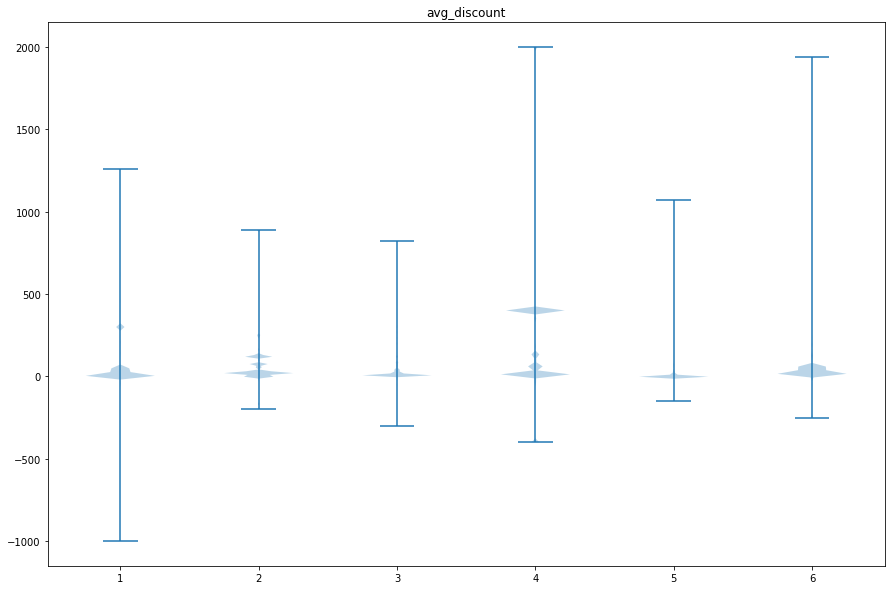

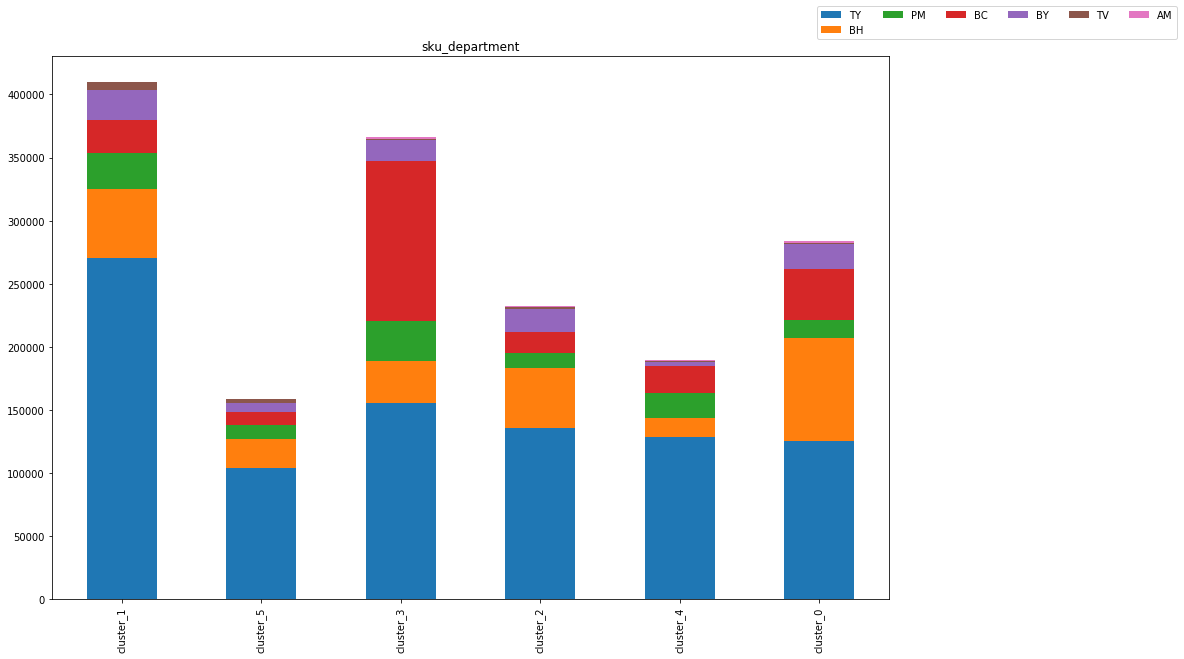

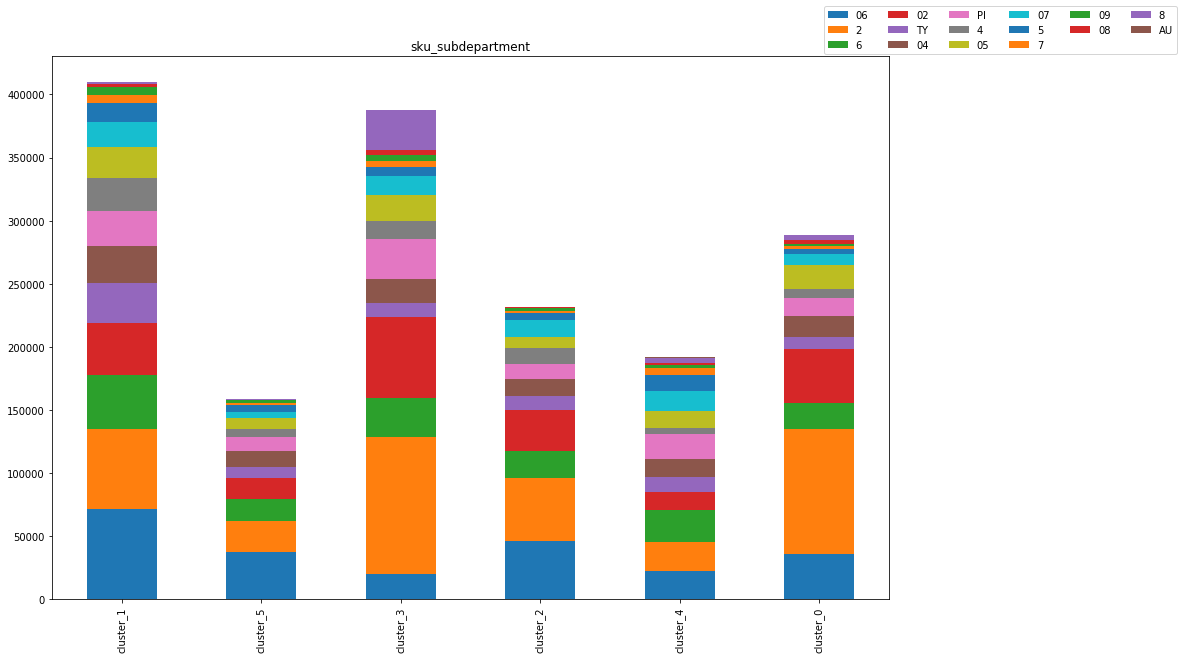

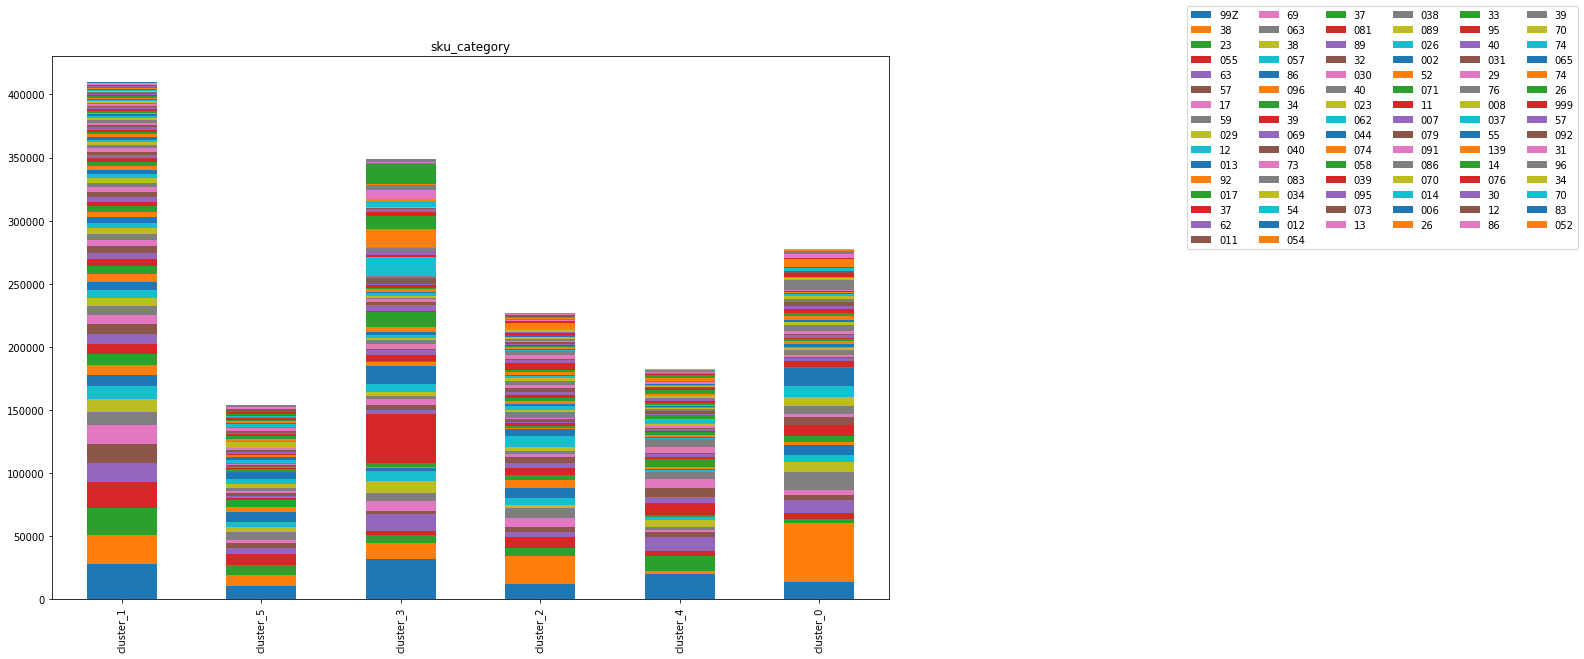

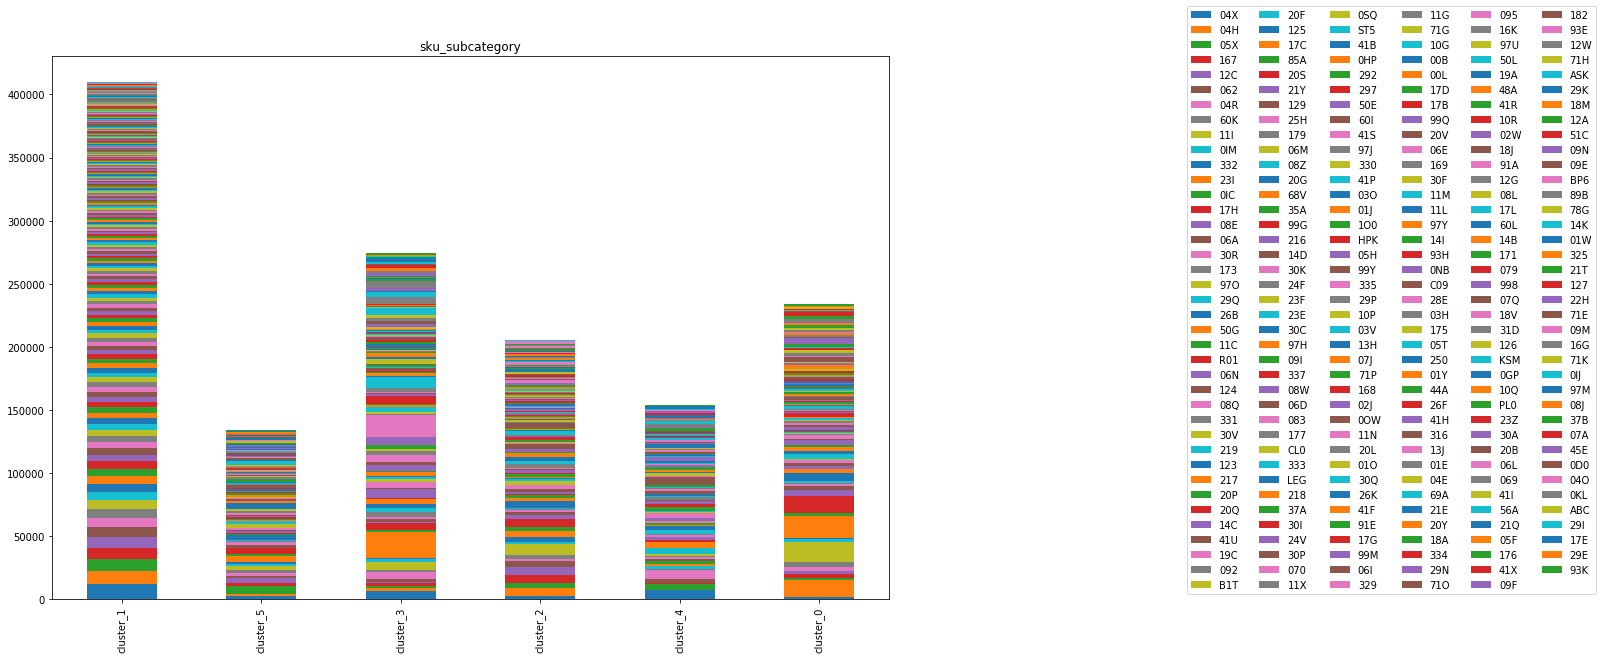

In [57]:
tsne_clus = pd.read_csv('tsne_clusters.csv')
tsne_clus.columns = ['sku_key', 'cluster']

analyze_tsne = AnalyzeClusters()
df_dict = analyze_tsne.make_dataset(product_sales, tsne_clus)

analyze_tsne.plot_cluster_continuous(df_dict, run_cont, colors, False)
analyze_tsne.plot_cluster_continuous_box(df_dict, run_cont, False)
analyze_tsne.plot_cluster_continuous_violin(df_dict, run_cont, False)
analyze_tsne.plot_cluster_categorical(df_dict, run_cats, False)

In [24]:
analyze_som.test_continuous_feat(df_dict, run_cont)


 
 sales
                sum_sq         df             F  PR(>F)
cluster   7.477739e+05        5.0  14252.904281     0.0
Residual  1.756681e+07  1674156.0           NaN     NaN 

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
cluster_0 cluster_1 -0.4328  -0.4552 -0.4104  True 
cluster_0 cluster_2 -0.4858  -0.5115 -0.4601  True 
cluster_0 cluster_3  1.2118   1.1892  1.2345  True 
cluster_0 cluster_4  0.4545   0.4274  0.4817  True 
cluster_0 cluster_5 -0.4209  -0.4497 -0.3921  True 
cluster_1 cluster_2  -0.053   -0.077 -0.0291  True 
cluster_1 cluster_3  1.6446   1.624   1.6653  True 
cluster_1 cluster_4  0.8873   0.8618  0.9128  True 
cluster_1 cluster_5  0.0119  -0.0154  0.0391 False 
cluster_2 cluster_3  1.6976   1.6735  1.7218  True 
cluster_2 cluster_4  0.9403   0.9119  0.9688  True 
cluster_2 cluster_5  0.0649   0.0348  0.0949  True 
cluster_3 cluster_4 -0.7573   -0.783 -0.

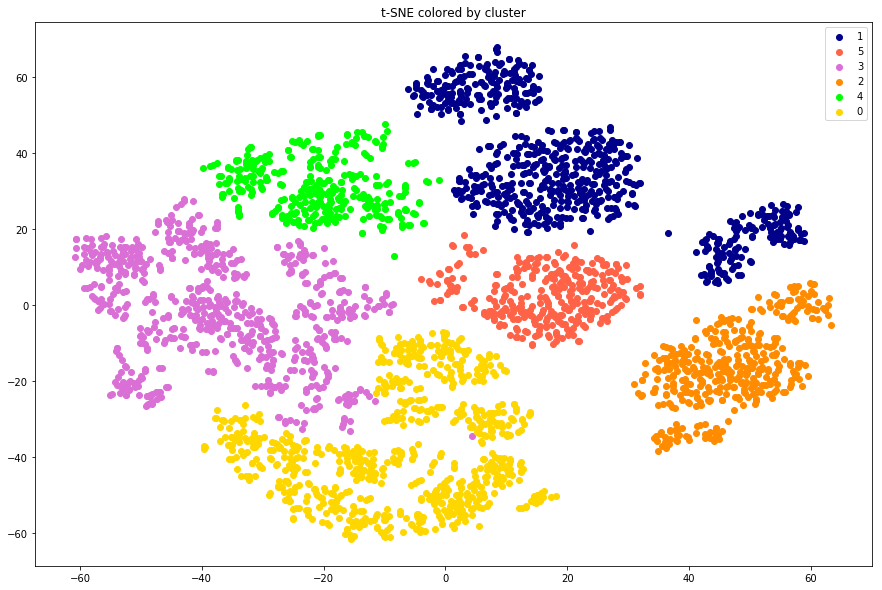

In [58]:
tsne_tsne = plot_df.merge(tsne_clus, left_on='id', right_on='sku_key')

plot_by_factor(tsne_tsne, 'cluster', colors, False)

In [26]:
tsne_sales_df = sales_df.merge(tsne_clus, on='sku_key')
tsne_sales_df.head()

,sku_key,sales,0,1,class,sales_log,cluster
0,28,119,22.483915,25.307186,175,2.075547,1
1,34,122,18.813700,5.753131,175,2.086360,5
2,100,1530,-53.056255,13.143605,2000,3.184691,3
3,152,44,48.061001,-24.166861,25,1.643453,2
4,182,914,-25.316551,24.063744,775,2.960946,4


cluster 1
697


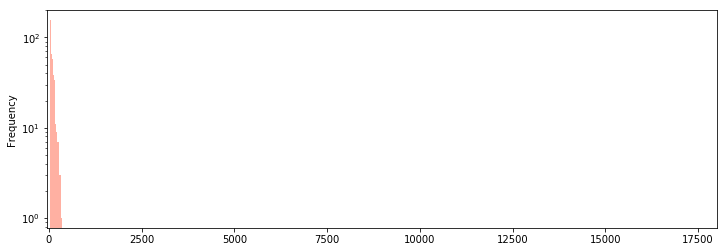

cluster 5
324


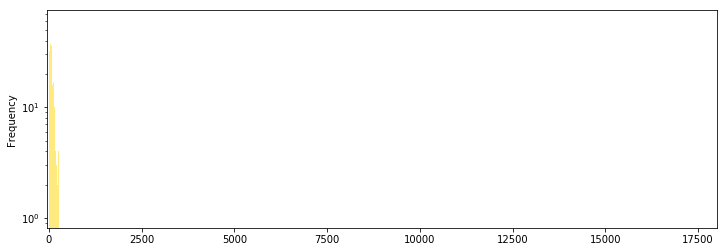

cluster 3
701


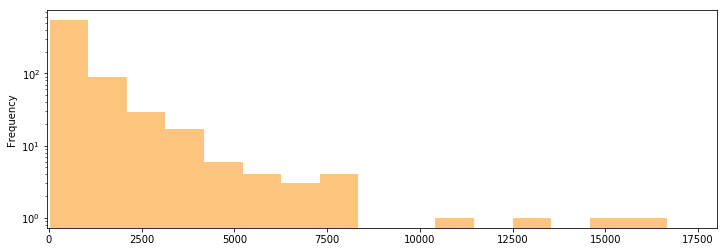

cluster 2
400


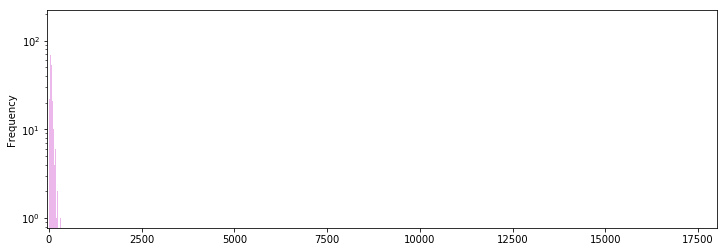

cluster 4
317


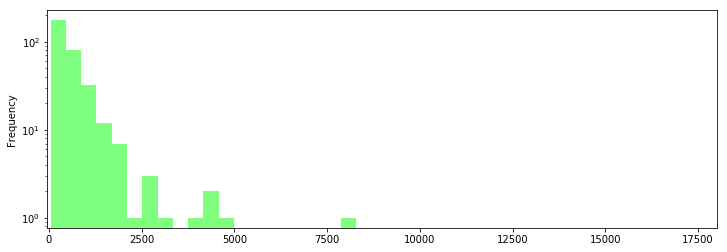

cluster 0
754


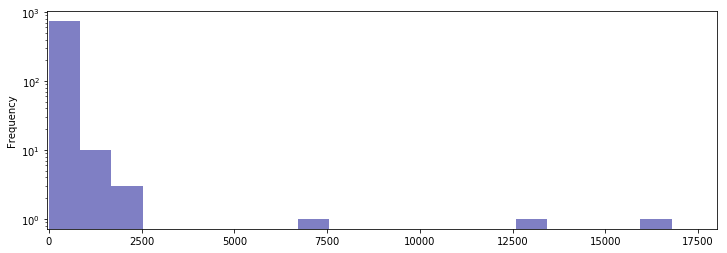

In [27]:
for i in tsne_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(tsne_sales_df[tsne_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    tsne_sales_df[tsne_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 18000)
    plt.show()
    f.savefig('images/tsne/tsne_cumulativesales_{}.png'.format(i))

In [28]:
for a, i in enumerate(tsne_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(tsne_sales_df[tsne_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(tsne_sales_df[tsne_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


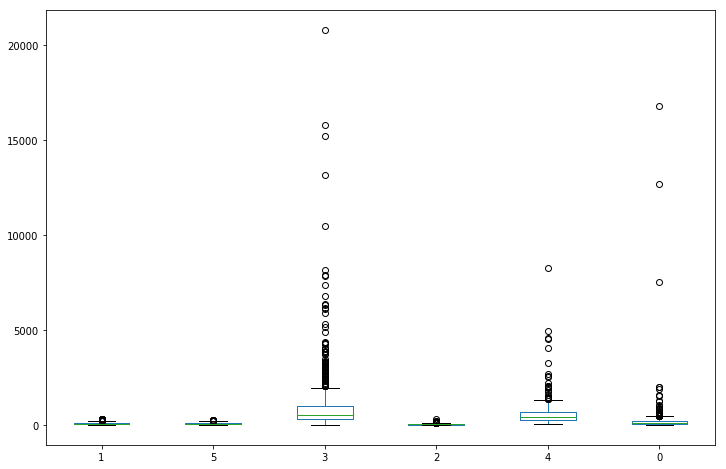

In [29]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)
f.savefig('images/tsne/tsne_cumulativesales_box.png')

In [30]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

,cluster,value
0,1,119.0
11,1,37.0
12,1,29.0
13,1,47.0
21,1,39.0


In [31]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df          F        PR(>F)
cluster   6.357657e+07     1.0  67.604399  2.874138e-16
Residual  3.000882e+09  3191.0        NaN           NaN


In [32]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower      upper   reject
---------------------------------------------------
  0      1    -135.4668 -271.5291    0.5956  False 
  0      2    -167.3545 -327.5291   -7.1799   True 
  0      3     774.445   638.5845   910.3054  True 
  0      4     405.7057  232.3709   579.0405  True 
  0      5    -144.5666 -316.5782   27.4449  False 
  1      2     -31.8877 -194.3166   130.5412 False 
  1      3     909.9117  771.4006  1048.4228  True 
  1      4     541.1725  365.7524   716.5926  True 
  1      5     -9.0999  -183.2125   165.0128 False 
  2      3     941.7995  779.5396  1104.0593  True 
  2      4     573.0602  378.3422   767.7783  True 
  2      5     22.7879  -170.7532   216.3289 False 
  3      4    -368.7392 -544.0028  -193.4757  True 
  3      5    -919.0116 -1092.9665 -745.0566  True 
  4      5    -550.2724 -754.8383  -345.7065  True 
---------------------------------------------------


## Dynamic Time Warping

In [33]:
from scipy.cluster.hierarchy import dendrogram, fcluster
from dtaidistance import dtw, dtw_visualisation, clustering
from dtaidistance import dtw_visualisation as dtwvis
import pickle

In [34]:
model = pickle.load(open('model.pkl', 'rb'))

In [35]:
product_ts = pd.pivot_table(sales, values='sales',
                            index='sku_key', columns='tran_date')
product_ts['nas'] = product_ts.apply(lambda x: x.isna()).sum(axis=1)
product_ts = product_ts.sort_values('nas', ascending=True).drop('nas', axis=1)

In [36]:
threshold = 6
clusters = fcluster(model.linkage, threshold, criterion='inconsistent', depth=10)
dtw_df = product_ts.reset_index()
dtw_df['cluster'] = clusters
output_df = dtw_df[['sku_key', 'cluster']]
print('Outputting...')
output_df.to_csv('dtw_clusters.csv', index=False)

Outputting...


In [37]:
clusters_dtw = pd.read_csv('dtw_clusters.csv')
clusters_dtw.columns = ['sku_key', 'cluster']

In [40]:
len(clusters_dtw['cluster'].unique())

9

In [60]:
dtw_tsne = plot_df.merge(clusters_dtw, left_on='id', right_on='sku_key')

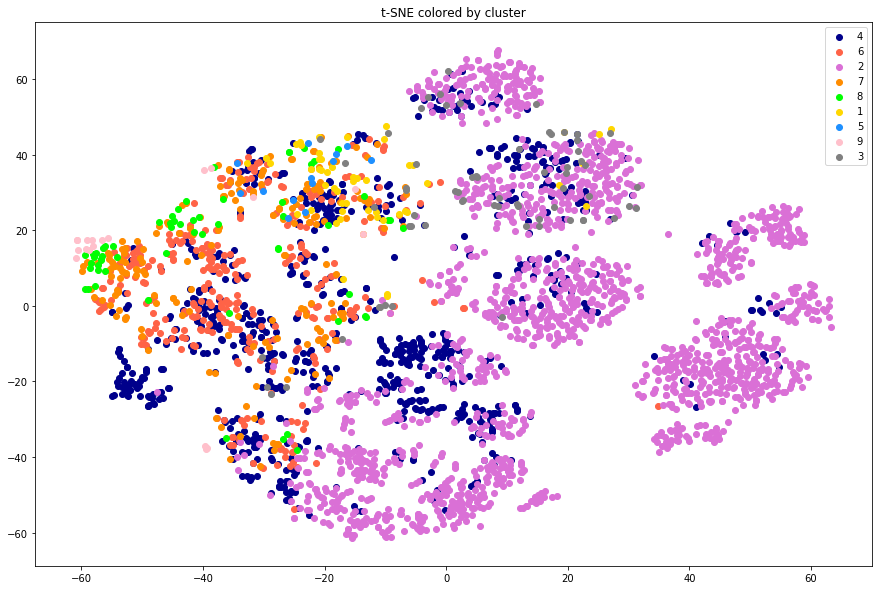

In [61]:
analyze_dtw = AnalyzeClusters()
df_dict = analyze_dtw.make_dataset(product_sales, clusters_dtw)

colors = ['darkblue', 'tomato', 'orchid', 'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r', 'brown']

plot_by_factor(dtw_tsne, 'cluster', colors, False)



 sku_department


 sku_subdepartment


 sku_category


 sku_subcategory


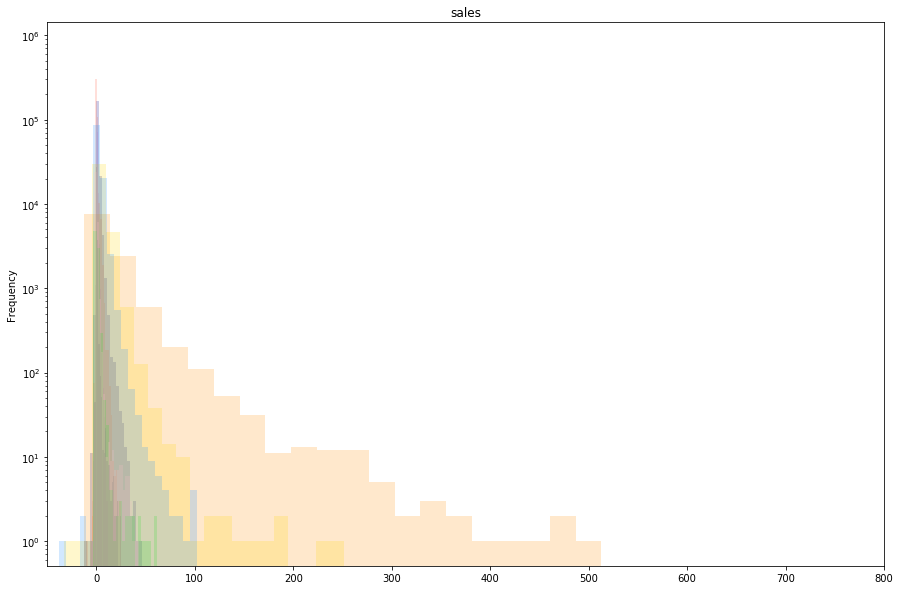

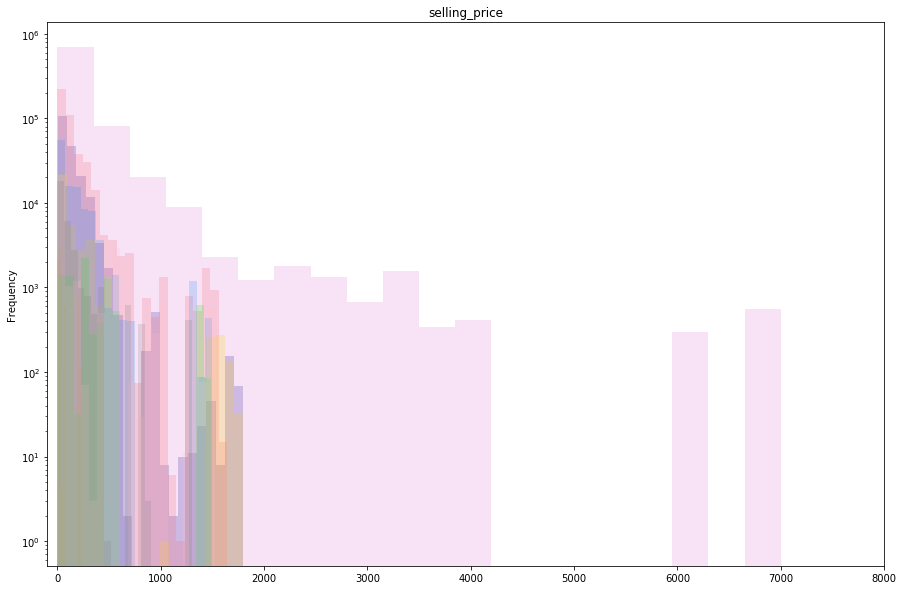

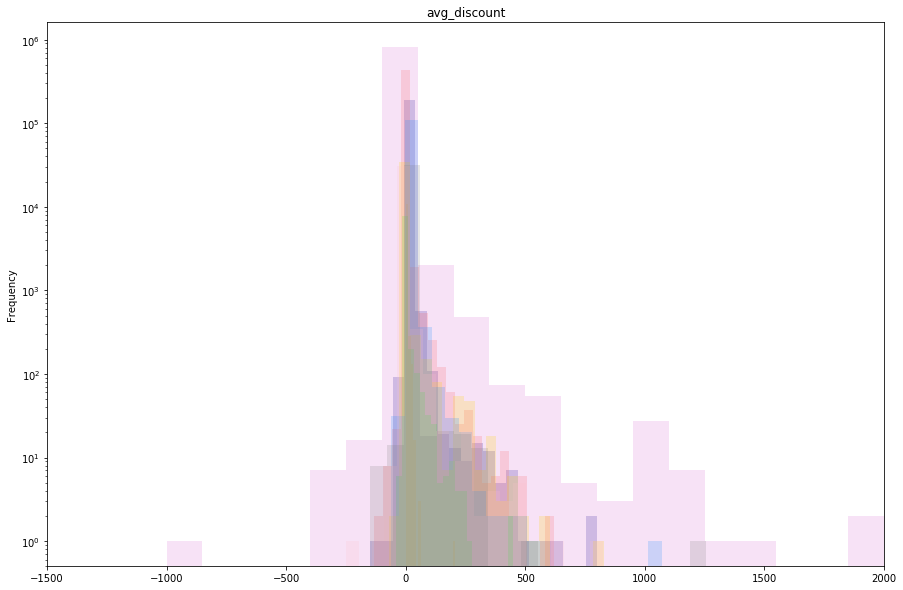

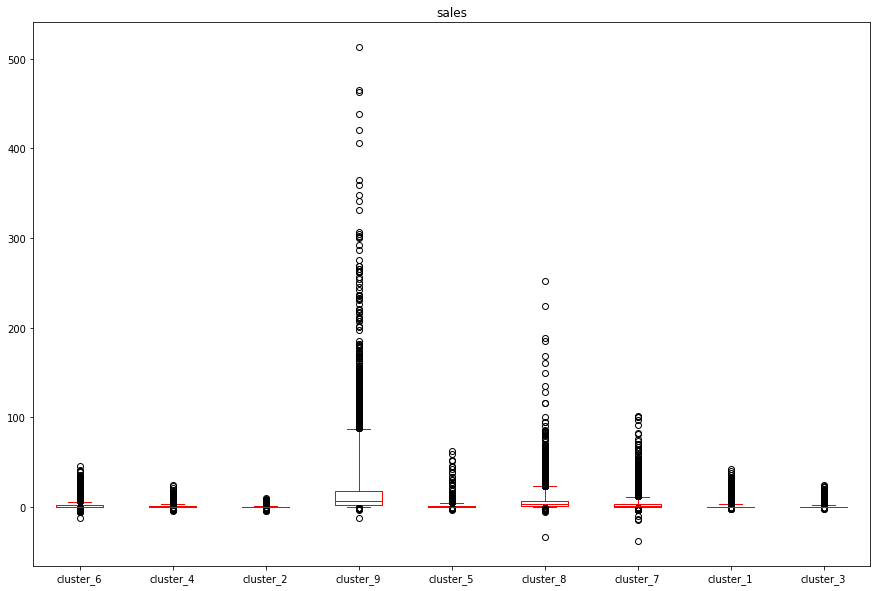

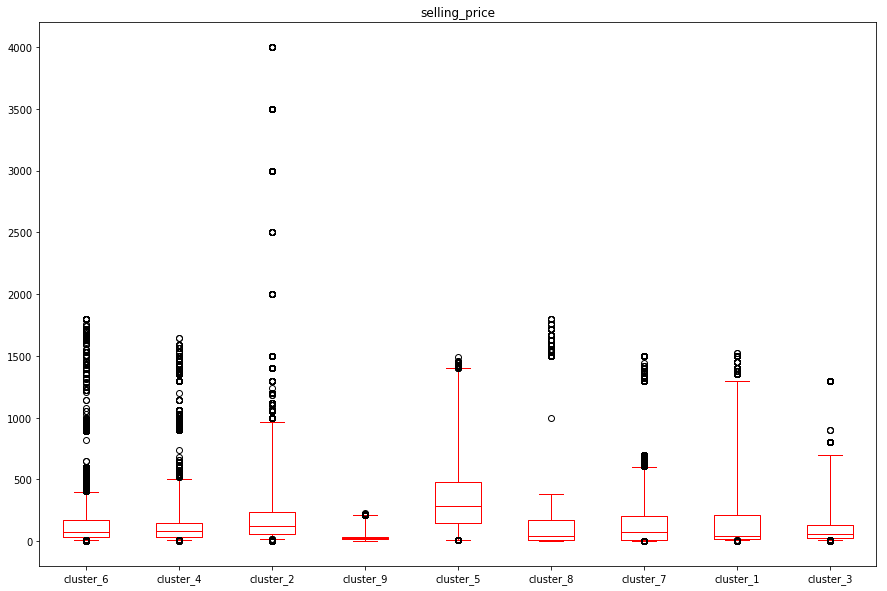

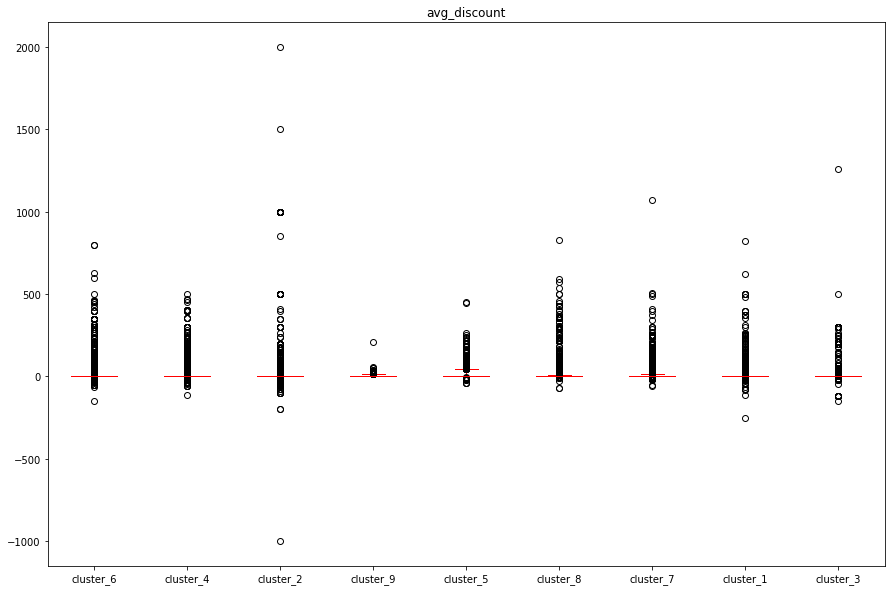

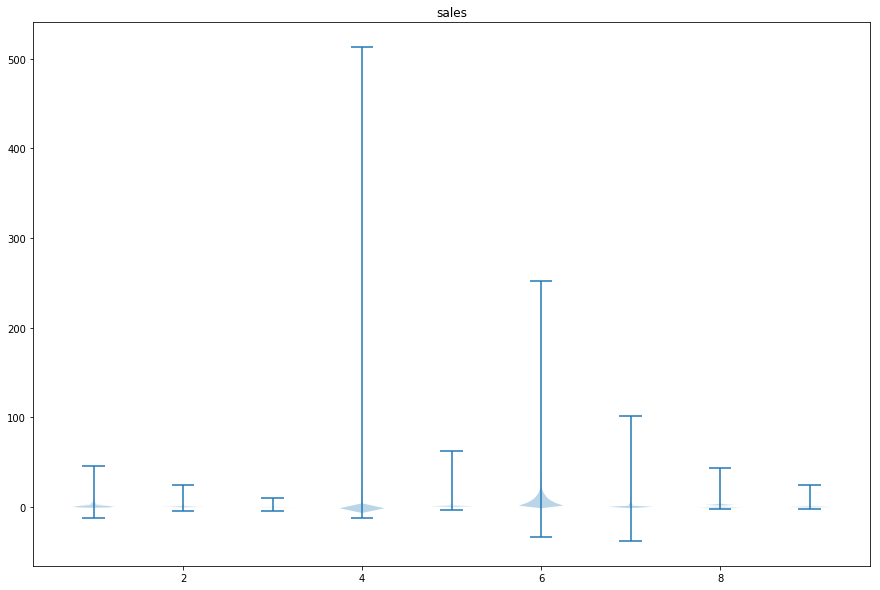

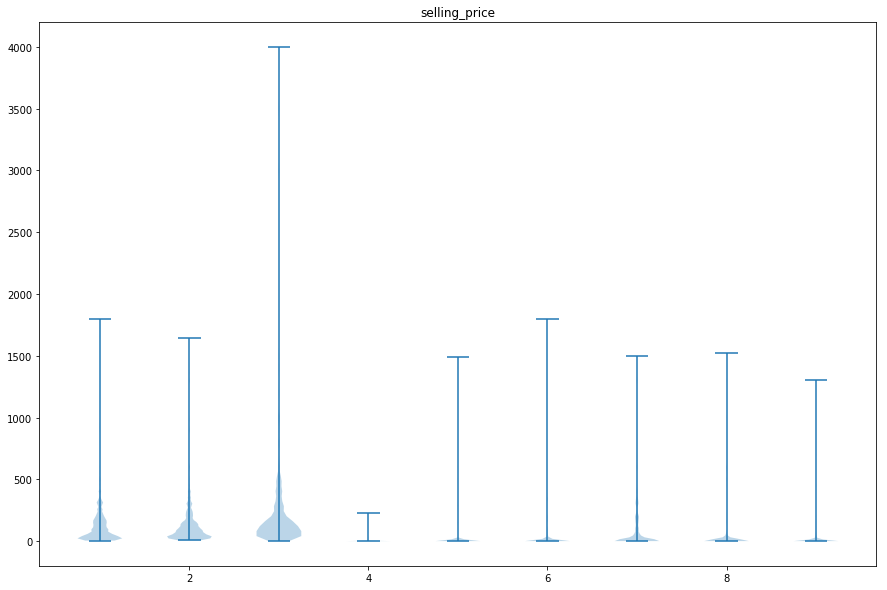

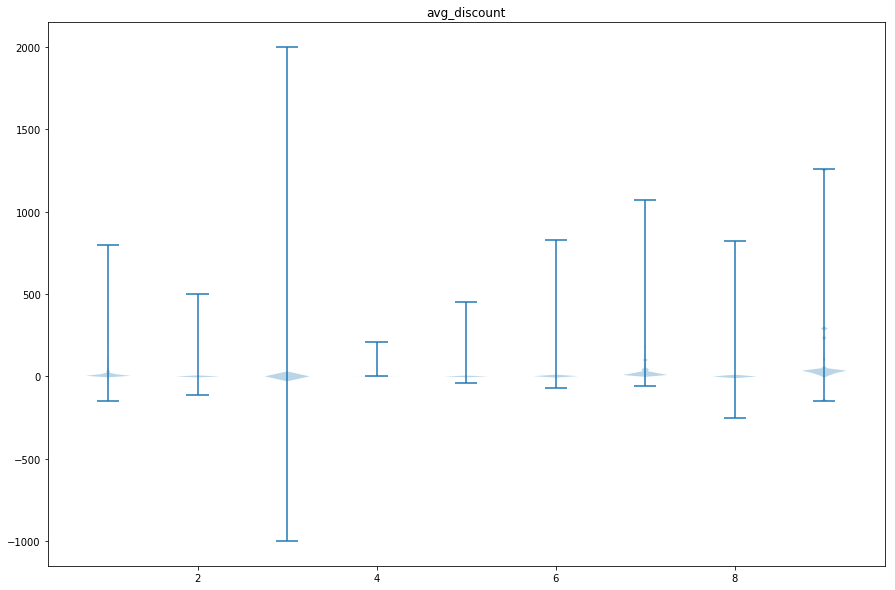

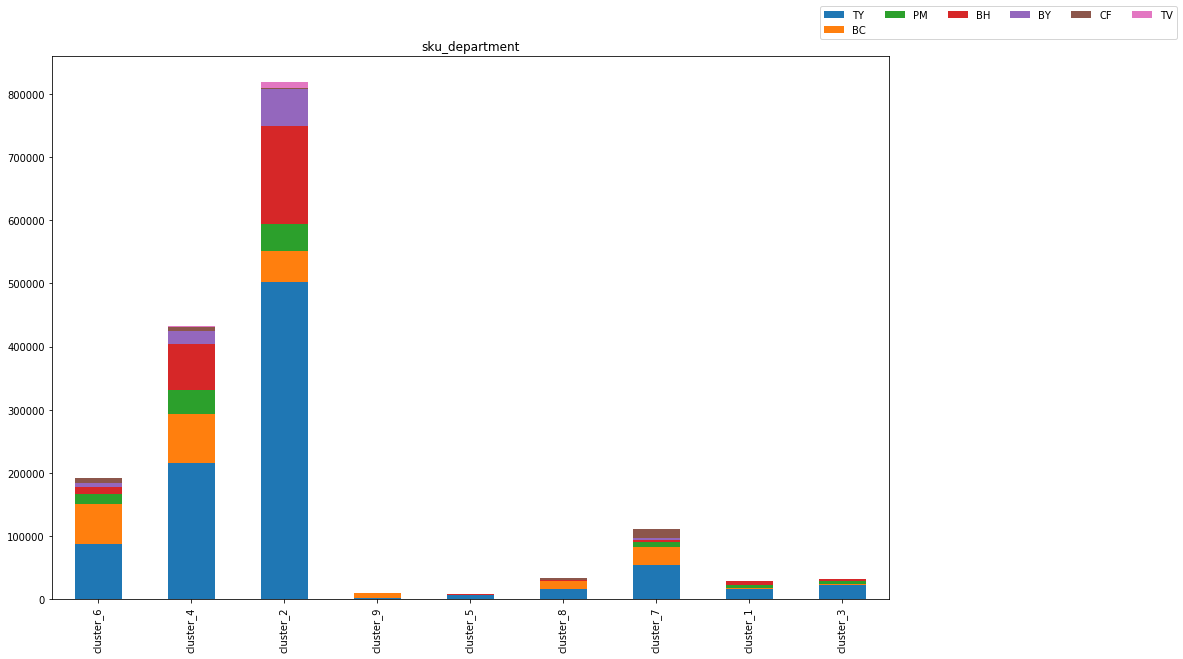

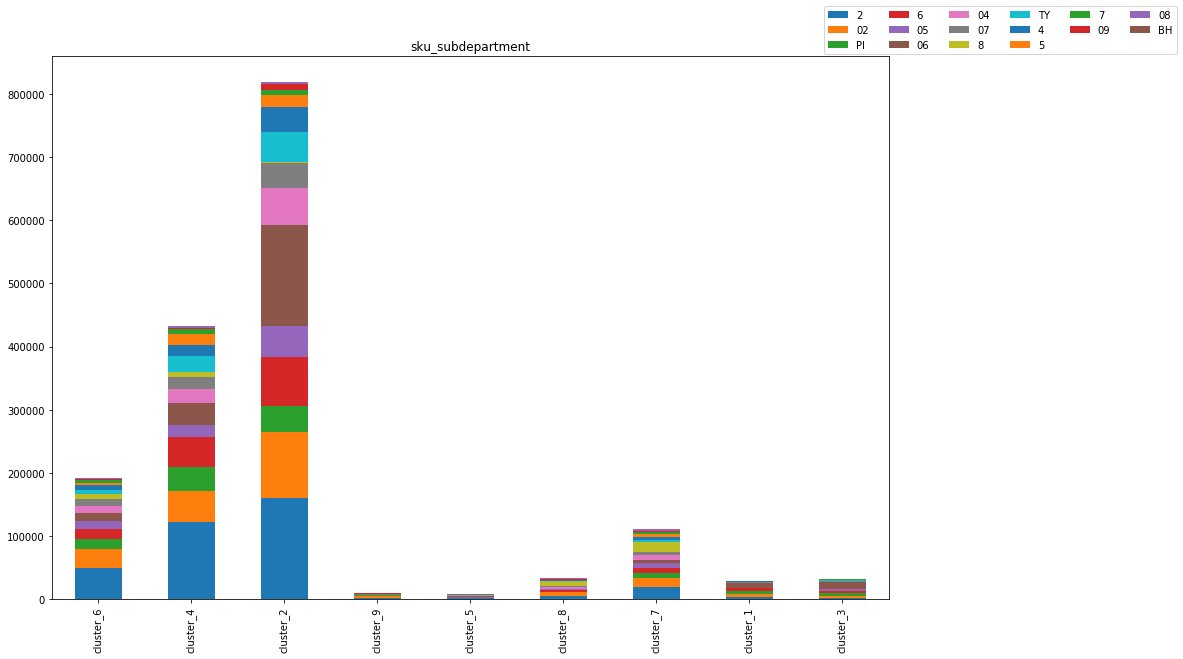

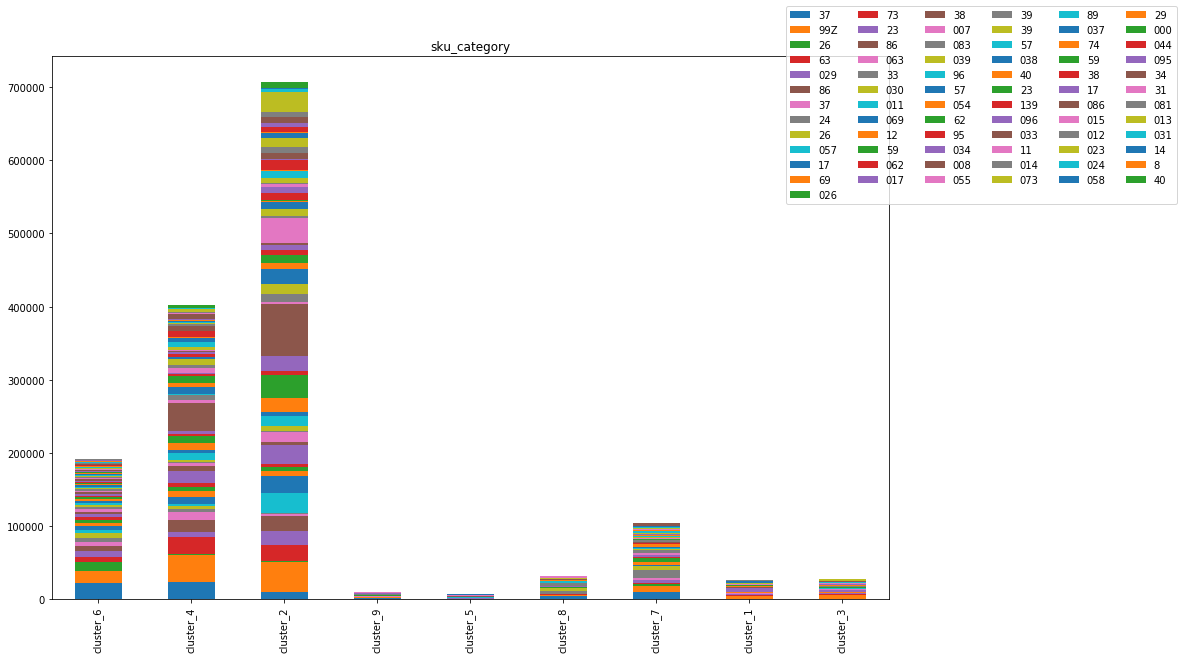

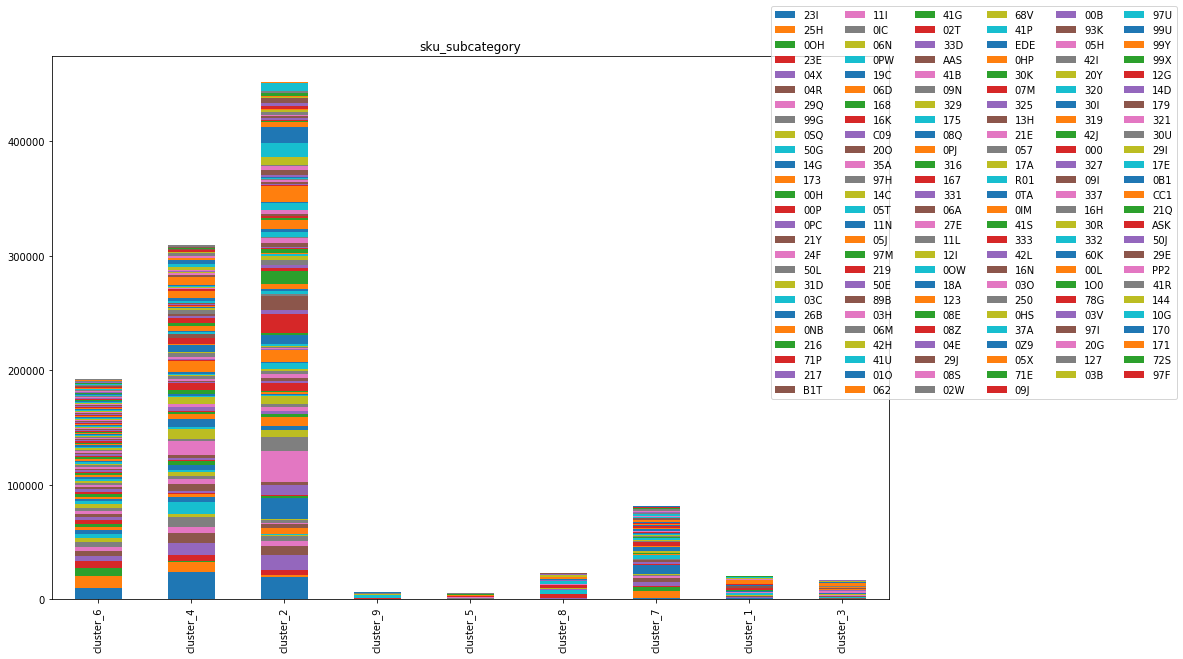

In [63]:
analyze_dtw.plot_cluster_continuous(df_dict, run_cont, colors, False)
analyze_dtw.plot_cluster_continuous_box(df_dict, run_cont, False)
analyze_dtw.plot_cluster_continuous_violin(df_dict, run_cont, False)
analyze_dtw.plot_cluster_categorical(df_dict, run_cats, False)

In [44]:
analyze_som.test_continuous_feat(df_dict, run_cont)


 
 sales
                sum_sq        df             F  PR(>F)
cluster   3.546965e+06       8.0  25696.462107     0.0
Residual  1.390548e+07  805921.0           NaN     NaN 

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
cluster_1 cluster_2 -0.2991   -0.378 -0.2202  True 
cluster_1 cluster_3 -0.2178  -0.3207  -0.115  True 
cluster_1 cluster_4  0.0553  -0.0236  0.1342 False 
cluster_1 cluster_5  0.4388   0.2788  0.5987  True 
cluster_1 cluster_6  0.6909   0.612   0.7698  True 
cluster_1 cluster_7  1.7886   1.7058  1.8714  True 
cluster_1 cluster_8  4.6355   4.5352  4.7358  True 
cluster_1 cluster_9 15.8826   15.74  16.0252  True 
cluster_2 cluster_3  0.0813   0.0033  0.1592  True 
cluster_2 cluster_4  0.3544   0.3128  0.3959  True 
cluster_2 cluster_5  0.7379   0.5927  0.883   True 
cluster_2 cluster_6   0.99    0.9484  1.0315  True 
cluster_2 cluster_7  2.0877   2.0391  2.136

In [45]:
dtw_sales_df = sales_df.merge(clusters_dtw, on='sku_key')
dtw_sales_df.head()

,sku_key,sales,0,1,class,sales_log,cluster
0,28,119,22.483915,25.307186,175,2.075547,4
1,34,122,18.813700,5.753131,175,2.086360,4
2,100,1530,-53.056255,13.143605,2000,3.184691,6
3,152,44,48.061001,-24.166861,25,1.643453,2
4,182,914,-25.316551,24.063744,775,2.960946,6


cluster 4
772


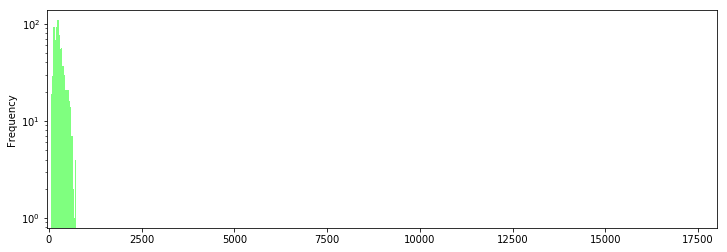

cluster 6
345


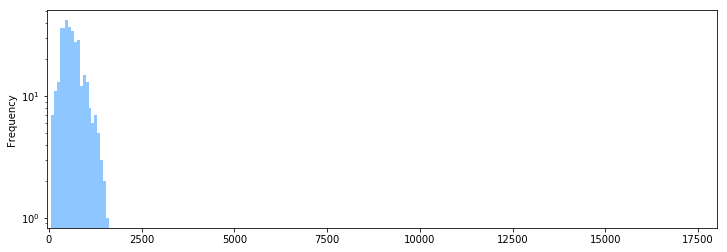

cluster 2
1677


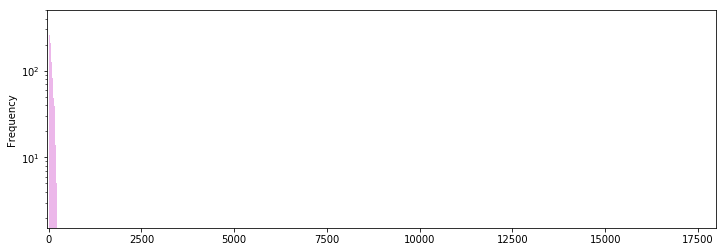

cluster 7
189


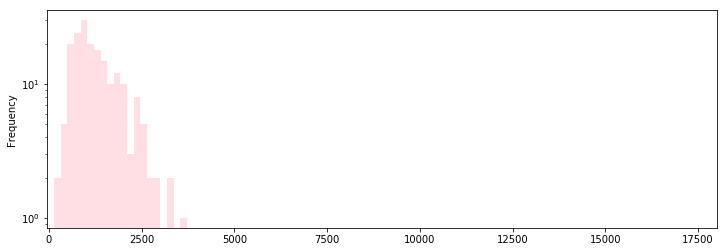

cluster 8
60


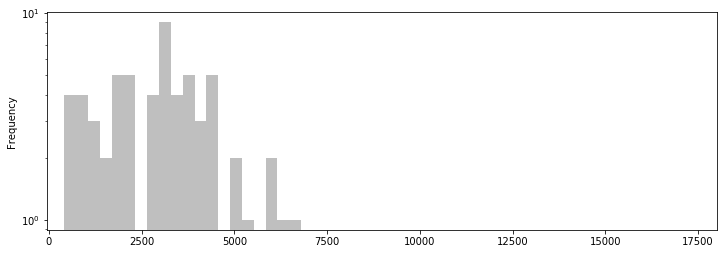

cluster 1
52


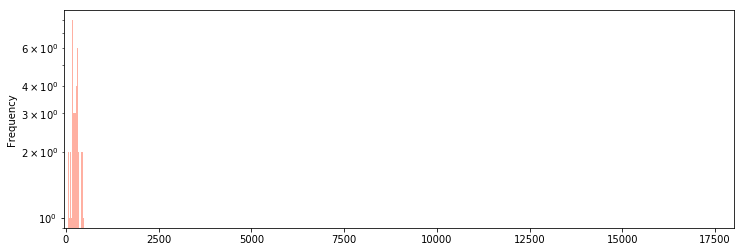

cluster 5
13


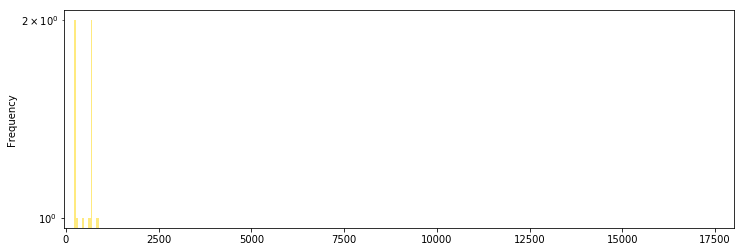

cluster 9
19


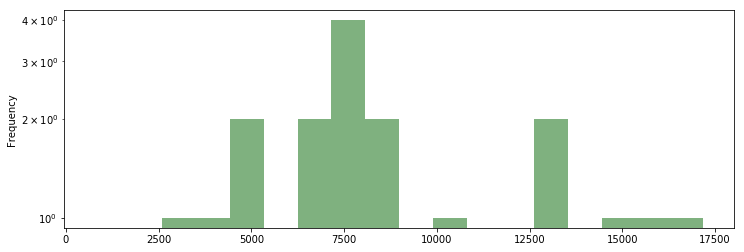

cluster 3
66


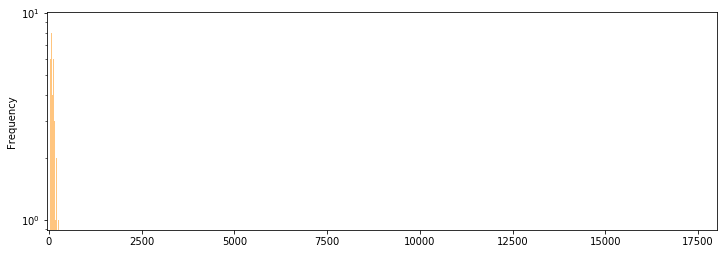

In [46]:
for i in dtw_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(dtw_sales_df[dtw_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    dtw_sales_df[dtw_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 18000)
    plt.show()
    f.savefig('images/dtw/dtw_cumulativesales_{}.png'.format(i))

In [47]:
for a, i in enumerate(dtw_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(dtw_sales_df[dtw_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(dtw_sales_df[dtw_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


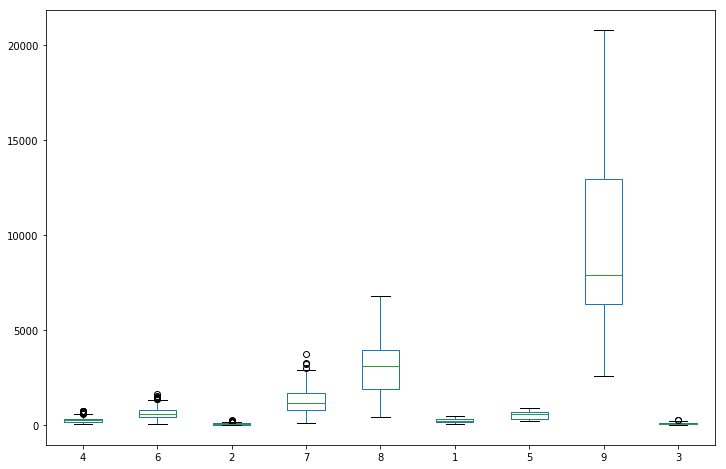

In [48]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)
f.savefig('images/dtw/dtw_cumulativesales_box.png')

In [49]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

,cluster,value
0,4,119.0
1,4,122.0
5,4,334.0
7,4,259.0
8,4,238.0


In [50]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df            F         PR(>F)
cluster   1.003551e+09     1.0  1553.844365  3.127023e-277
Residual  2.060908e+09  3191.0          NaN            NaN


In [51]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
  1      2    -188.6047 -394.7226  17.5133  False 
  1      3    -153.5816 -425.0092  117.846  False 
  1      4     22.6167  -187.1033  232.3367 False 
  1      5     293.0769 -160.8333  746.9871 False 
  1      6     369.2994  151.5432  587.0557  True 
  1      7      1049.7   820.4747 1278.9253  True 
  1      8    2729.0821 2451.7383 3006.4258  True 
  1      9    9268.1943 8875.7868 9660.6018  True 
  2      3     35.0231  -148.6717  218.7178 False 
  2      4     211.2213  147.5556  274.8871  True 
  2      5     481.6816  74.1214   889.2418  True 
  2      6     557.9041  471.3672  644.4409  True 
  2      7    1238.3047 1125.9878 1350.6216  True 
  2      8    2917.6867 2725.3579 3110.0155  True 
  2      9     9456.799 9119.0794 9794.5185  True 
  3      4     176.1983  -11.5293  363.9258 False 
  3      5     446.6585   2.481